# Rocket Engine Nozzle Mesh Generator (Beginner-Friendly Guide)

This Jupyter Notebook helps you **generate 2D and 3D mesh geometries** for rocket engine nozzles, focusing on real datas (not included), but also allowing for custom designs. It uses the [GMSH](https://gmsh.info/) Python API for geometry creation and meshing, and supports advanced features like cooling channels and reinforcement ribs.

---

## What Does This Notebook Do?

- **Loads real or custom nozzle geometry data** (from CSV or parameters)
- **Builds the nozzle shape** using mathematical curves or real data
- **Adds cooling channels and reinforcements** to the nozzle wall
- **Creates 3D geometry** by revolving 2D profiles around the nozzle axis
- **Generates a mesh** suitable for simulation (CFD, FEA, etc.)
- **Exports the mesh** to standard formats (`.msh`, `.stl`) for use in other tools

---

## Main Features

- **Real Data Integration:** Use real rocket engine data for accurate geometry.
- **Custom Geometry:** Easily switch to your own nozzle parameters.
- **Profile Generation:** Supports Bézier and de Laval curves for smooth shapes.
- **Cooling Channels:** Automatically create and subtract cooling circuits from the nozzle wall.
- **Radial Reinforcements:** Add reinforcement ribs at specified positions.
- **Physical Group Management:** Keeps track of different parts of the geometry for easy simulation setup.
- **Visualization:** Plots profiles and geometry for easy verification.

---

## How to Use This Notebook

### 1. **Dependencies**

The notebook uses these Python packages:
- `gmsh`
- `numpy`
- `matplotlib`
- `scipy`
- `pandas`
- `math`

If any are missing, the notebook will try to install them automatically.

---

### 2. **Workflow Overview**

1. **Imports & Checks:**  
   Ensures all required packages are available.

2. **Load Geometry Data:**  
   - Use real Vulcain 2.1 data (from CSV) or
   - Define your own nozzle parameters.

3. **Set Parameters:**  
   - Wall thickness, number of cooling channels, mesh resolution, etc.

4. **Initialize GMSH:**  
   - Set mesh size and options.

5. **Geometry Creation:**  
   - Build 2D profiles for the nozzle and channels.
   - Revolve profiles to create 3D geometry.

6. **Add Features:**  
   - Add cooling channels and reinforcements.

7. **Mesh Generation:**  
   - Generate and export the mesh.

---

### 3. **Basic Example**

To generate a nozzle with a cooling circuit, run:

```python
mesh_generator("Solid", path_for_save="Rocket_Engine_Meshes/", debug=True)
```

You can also generate just the inner fluid, outer fluid, or only the cooling channels by changing the argument to `"Inner_Fluid"`, `"Outer_Fluid"`, or `"Cooling_Channels"`.

---

### 4. **Visualization**

- The notebook plots the nozzle and channel profiles so you can check the geometry before meshing.
- You can open the generated `.msh` or `.stl` files in the GMSH GUI for 3D inspection.

---

### 5. **Customization Tips**

- **Change Geometry:**  
  Edit the parameters or CSV files to use your own nozzle shape.
- **Adjust Mesh Quality:**  
  Change mesh size parameters for finer or coarser meshes.
- **Add/Remove Features:**  
  Set the number of cooling channels or reinforcements as needed.

---

## Troubleshooting

- **No Elements in Volume Error:**  
  This means the geometry is not closed or valid. Check your parameters and input data.
- **Mesh Not Exported:**  
  Make sure all geometry steps complete without errors before meshing.

---

**Tip:**  
If you are new to GMSH or mesh generation, start by running the notebook as-is, then gradually change parameters and observe the effects on the geometry and mesh.

In [161]:
import os
import warnings
import time

try:
    import gmsh
except ImportError:
    print("gmsh is not installed. Trying to install it...")
    os.system("pip install gmsh")
    import gmsh
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("matplotlib is not installed. Trying to install it...")
    os.system("pip install matplotlib")
    import matplotlib.pyplot as plt
try:
    import numpy as np
except ImportError:
    print("numpy is not installed. Trying to install it...")
    os.system("pip install numpy")
    import numpy as np
    
try: 
    import scipy
    from scipy.optimize import linear_sum_assignment
    from scipy.sparse.csgraph import minimum_spanning_tree
except ImportError:
    print("scipy is not installed. Trying to install it...")
    os.system("pip install scipy")
    import scipy
    from scipy.optimize import linear_sum_assignment
    from scipy.sparse.csgraph import minimum_spanning_tree

try:
    import pandas as pd
except ImportError:
    print("pandas is not installed. Trying to install it...")
    %pip install pandas
    import pandas as pd

try:
    import math
except ImportError:
    print("math is not installed. Trying to install it...")
    %pip install math
    import math
    
try:
    import scipy.interpolate
except ImportError:
    print("scipy.interpolate is not installed. Trying to install it...")
    %pip install scipy
    import scipy.interpolate

try: 
    import threading
except ImportError:
    print("threading is not installed. Trying to install it...")
    %pip install threading
    import threading

In [162]:
### === CSV data extractor === ###

def csv_extractor(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls):
    """
    This function extracts the geometry from a CSV file and returns the values as a dataframe.
    input: 
    file_name: names of the CSV files
    columns_names: list of column names to extract
    output: values: dataframes containing the values from the CSV file 
    """
    # Read the CSV file with specified column names
    # The first row is the header, so we need to skip it
    df_interior = pd.read_csv(file_name_interior, names=columns_names_interior, header=0)
    df_walls = pd.read_csv(file_name_walls, names=columns_names_walls, header=0)
    
    return df_interior, df_walls

def width_by_method(x, method, function, derivative, debug = False):
    if method == "ortho":
        return function(x)
    if method == "angle":
        # Calculate the angle using the derivative
        angle = math.atan(derivative(x))
        # Calculate the width using the angle
        y_factor = math.cos(angle)
        initial_width = function(x) * y_factor
        x_factor = math.sin(angle)
        x_used = x + x_factor* initial_width
        width = function(x_used) * y_factor
        if debug:
            return width, x_factor * initial_width
        return width

def geometry_creator(dataframe_interior, dataframe_wall, method, debug = False):
    """
    This function creates the geometry from the dataframe and returns the values as a list.
    input: 
    dataframe: dataframe containing the values from the CSV file
    method: method for the extraction of the geometry for the angle : "ortho" or "angle"
    output: values: list containing the values from the CSV file 
    """
    # Extract the values from the dataframe
    x_interior = dataframe_interior["x"].values
    y_interior = dataframe_interior["y"].values
    x_walls = dataframe_wall["x"].values
    channel_height = dataframe_wall["channel height"].values
    channel_width = dataframe_wall["channel width"].values
    hot_gas_wall = dataframe_wall["hot gas wall"].values
    outer_thickness = dataframe_wall["outer thickness"].values
    number_channels = dataframe_wall["number channels"].values

    # Interpolate functions for the different values
    interior_func = scipy.interpolate.interp1d(x_interior, y_interior, kind='linear', fill_value="extrapolate")
    channel_height_func = scipy.interpolate.interp1d(x_walls, channel_height, kind='linear', fill_value="extrapolate")
    channel_width_func = scipy.interpolate.interp1d(x_walls, channel_width, kind='linear', fill_value="extrapolate")
    hot_gas_wall_func = scipy.interpolate.interp1d(x_walls, hot_gas_wall, kind='linear', fill_value="extrapolate")
    outer_thickness_func = scipy.interpolate.interp1d(x_walls, outer_thickness, kind='linear', fill_value="extrapolate")
    number_channels_func = scipy.interpolate.interp1d(x_walls, number_channels, kind='linear', fill_value="extrapolate")
        
    # Calculate the derivatives of the functions to get their angles
    interior_derivative = np.gradient(interior_func(x_interior), x_interior)
    channel_height_derivative = np.gradient(channel_height_func(x_walls), x_walls)
    hot_gas_wall_derivative = np.gradient(hot_gas_wall_func(x_walls), x_walls)
    outer_thickness_derivative = np.gradient(outer_thickness_func(x_walls), x_walls)

    # Interpolate the derivatives to get the values at the same points as the functions
    interior_derivative = scipy.interpolate.interp1d(x_interior, interior_derivative, kind='linear', fill_value="extrapolate")
    channel_height_derivative = scipy.interpolate.interp1d(x_walls, channel_height_derivative, kind='linear', fill_value="extrapolate")
    hot_gas_wall_derivative = scipy.interpolate.interp1d(x_walls, hot_gas_wall_derivative, kind='linear', fill_value="extrapolate")
    outer_thickness_derivative = scipy.interpolate.interp1d(x_walls, outer_thickness_derivative, kind='linear', fill_value="extrapolate")
        
    # Create a new dataframe with the new values
    new_dataframe = pd.DataFrame(columns=["x", "nozzle inner wall", "nozzle outer wall", "channel inner wall", "channel outer wall", "channel width", "number channels"])
    for i,x in enumerate(x_interior):
        # We push x
        new_dataframe.loc[i, "x"] = x
        # First layer : the interior wall which is the first so the derivative is 0. We will jsut use the ortho method
        current_width = width_by_method(x, "ortho", interior_func, lambda x: 0)
        new_dataframe.loc[i, "nozzle inner wall"] = current_width
        # Second layer : the inner wall of the channel
        current_width = current_width +  width_by_method(x, method, hot_gas_wall_func, interior_derivative)
        new_dataframe.loc[i, "channel inner wall"] = current_width
        # Third layer : the outer wall of the channel
        current_width = current_width + width_by_method(x, method, channel_height_func, hot_gas_wall_derivative)
        new_dataframe.loc[i, "channel outer wall"] = current_width
        # Fourth layer : the outer wall of the channel
        current_width = current_width + width_by_method(x, method, outer_thickness_func, channel_height_derivative)
        new_dataframe.loc[i, "nozzle outer wall"] = current_width
        
        # Other values
        new_dataframe.loc[i, "channel width"] = channel_width_func(x)
        new_dataframe.loc[i, "number channels"] = int(number_channels_func(x))
    
    # Debug: plot the new values
    if debug:
        plt.plot(new_dataframe["x"], new_dataframe["nozzle inner wall"], label="nozzle inner wall")
        plt.plot(new_dataframe["x"], new_dataframe["nozzle outer wall"], label="nozzle outer wall")
        plt.plot(new_dataframe["x"], new_dataframe["channel inner wall"], label="channel inner wall")
        plt.plot(new_dataframe["x"], new_dataframe["channel outer wall"], label="channel outer wall")
        plt.xlabel("x")
        plt.ylabel("values")
        plt.title("New geometry values")
        plt.legend()
        plt.show()
        print(new_dataframe)
    
    return new_dataframe

def geometry_dataframe(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls, method, debug = False, minimum_caracteristic_length = False):
    """
    This function creates the geometry from the dataframe and returns the values as a list.
    input: 
    file_name: names of the CSV files
    columns_names: list of column names to extract
    method: method for the extraction of the geometry for the angle : "ortho" or "angle"
    output: values: list containing the values from the CSV file 
    """
    # Extract the geometry from the CSV file
    values = csv_extractor(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls)
    # Create the geometry
    geometry = geometry_creator(values[0], values[1], method)
    # Get the minimum caracteristic length
    if minimum_caracteristic_length:
        min_carac_length = min(min(values[1]["channel width"]), 
                               min(values[1]["channel height"]), 
                               min(values[1]["outer thickness"]), 
                               min(values[1]["hot gas wall"]))
        return geometry, min_carac_length
    return geometry

    

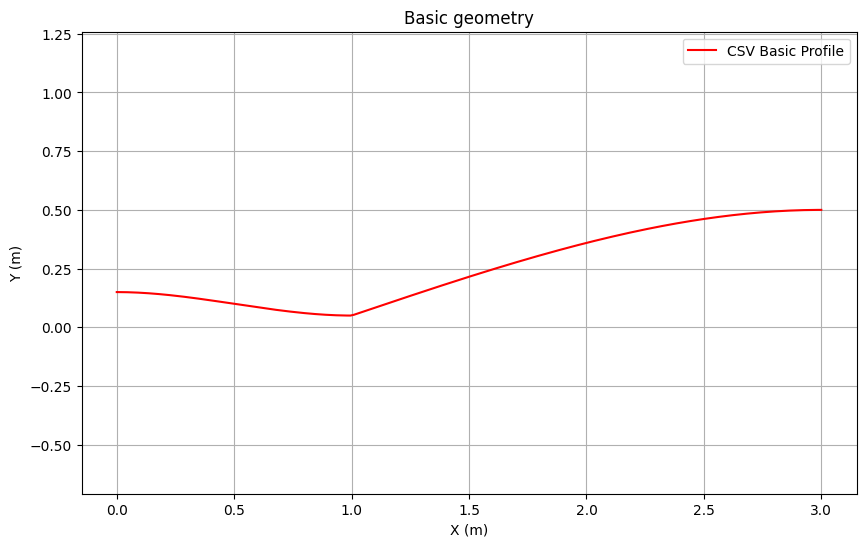

In [163]:
### === Parameters for the rocket engine geometry === ###

DEBUG = False
proximity_tol = 0.0001
MULTITHREADING = 10
DIM_MESH = 3 # Dimension of mesh generation (2 will give you a 3D mesh but possibly with false positive)

# Parameters for extracting the data from the CSV files
current_directory = os.getcwd()
file_name_interior = "nozzle_curve.csv"   #"hgw_input_placeholder.csv"
file_name_walls = "nozzle_layers.csv" #"geometry_input_placeholder_alt.csv"
columns_names_interior = ["x","y"]
columns_names_walls = ["x","channel height","channel width","hot gas wall","outer thickness","number channels"]
extracting_method="angle" # Method for the extraction of the geometry for the angle : "ortho" or "angle"
Multiplicator_X_CSV = 1.0

# Extract the geometry from the CSV file
geometry_data, min_carac_length = geometry_dataframe(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls, extracting_method, debug = False, minimum_caracteristic_length = True) 

# Multiply the length by N
geometry_data["x"] = geometry_data["x"] * Multiplicator_X_CSV

# We create a basic geometry with only X and Y in case of a need of simplicity
X_CSV = geometry_data["x"].values
Y_CSV = geometry_data["nozzle inner wall"].values

# Adapt X_Parameters and D_Parameters
plt.figure(figsize=(10, 6))
plt.plot(X_CSV, Y_CSV, 'r-', label='CSV Basic Profile')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
plt.title('Basic geometry')
plt.grid()
plt.legend()
plt.show()

#Parameters direclty from the CSV data
X_Start = X_CSV[0]  # Starting point of the nozzle
X_Exit = X_CSV[-1]  # Exit point
length = X_CSV[-1] - X_CSV[0]  # Length of the engine
chamber_length = X_CSV[np.where(Y_CSV == Y_CSV.min())[0][0]] - X_CSV[0]
nozzle_length = length - chamber_length
X_Throat = X_Start + chamber_length  # Adjust the throat position based on the chamber length
D_Start = Y_CSV[0] * 2 # Diameter at the start of the nozzle
D_Throat = Y_CSV.min() * 2  # Diameter at the throat
D_Exit = Y_CSV[-1] * 2 # Diameter at the exit

# Define the nozzle parameters
X_Parameters_Nozzle = [X_Start, X_Throat, X_Exit]  # X coordinates of the nozzle
D_Parameters_Nozzle = [D_Start, D_Throat, D_Exit]  # Diameter parameters of the nozzle
Nozzle_Angle_Revolution = np.pi / 4  # Angle of revolution for the nozzle
Nozzle_Modificator_Inner = lambda x: 0.
Nozzle_Modificator_Outer = lambda x: 0.

# Define the cooling circuit parameters
X_Cooling_Start = X_Start  # Starting point of the cooling circuit
X_Cooling_Throat = X_Throat  # Throat position of the cooling circuit
X_Cooling_Exit = X_Exit  # Exit position of the cooling circuit
X_Cooling_Parameters = [X_Cooling_Start, X_Cooling_Throat, X_Cooling_Exit]  # X coordinates of the cooling circuit
Cooling_Channel_Angle_Size = - np.pi / 16  # Deprecated: The width is defned by the CSV file
Cooling_Channel_Extension = chamber_length * 0.1  # Extension of the cooling channel
Cooling_Channel_Modificator_Inner = lambda x: 0.
Cooling_Channel_Modificator_Outer = lambda x: 0.
Cooling_Channel_Angle_Offset = 0.0 # Angle offset of the cooling channel as a multiplier between two channels. By default at 0.0 the first channel intersect with the side. ATTENTION, it could lead to topological problems if not used properly.

# Define the reinforcement parameters
Radial_Reinforcement_Width = 0.003  # Width of the radial reinforcement
Radial_Reinforcement_Height = 0.01  # Height of the radial reinforcement
Radial_Reinforcement_Number = 20 # Number of radial reinforcements
Radial_Reinforcement_Density = lambda x: x * 0  # Density of the radial reinforcement (x*0 to get a uniform distribution) It needs to return a numpy array !!
Radial_Reinforcement_Margin_Entry = 0.01  # Margin of the radial reinforcement at the entry
Radial_Reinforcement_Margin_Exit = 0.01  # Margin of the radial reinforcement at the exit

# Profile treatment Parameters
number_of_points_profile = 150  # Number of points for the nozzle profile
ratio_for_accel_points = 0.5  # Ratio of points selected for the acceleration in a reduction of points. The rest is uniformly distributed
reduce_points_method = 'density' # Method to reduce points: 'density' or 'accel' 

# Output parameters
Radius_Study_Margin = 0.1 # Added space for the exterior radius

# Initialize some variables
Angle_Revolution = Nozzle_Angle_Revolution
start_tag = 1

# Output files parameters
output_folder = os.path.join(current_directory, "Rocket_Engine_Meshes/")
output_in_stl = False
output_in_msh = True
other_type_output = None # Specify a .[type] to output the geometry in this format. If None, no other output is generated.

In [164]:
### === Parameters for GMSH === ###
def GMSH_initialise(caracteristic_length_min=0.0001, caracteristic_length_max=None, thread_number = 1):
    """
    Initialize GMSH with specific options.
    """
    # Check if caracteristic_length_max is None. If it is, set it to 100 times caracteristic_length_min
    if caracteristic_length_max is None:
        caracteristic_length_max = 1000*caracteristic_length_min
        
    # Initialize GMSH
    gmsh.initialize()
    
    gmsh.option.setNumber("General.Verbosity", 5)  # 2=Warning, 3=Info, 4=Debug, 5=Trace
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", caracteristic_length_max)  # maille max de 0.05
    gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 1)  # Adapt mesh size to curvature
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromCurvature", 1)  # Enable mesh size adaptation based on curvature
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", caracteristic_length_min/10)  # maille min de 0.0005
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # 6 = use the Frontal-Delaunay algorithm for mesh generation
    #gmsh.option.setNumber("Mesh.Algorithm3D", 10)  # 6 = use the Frontal-Delaunay algorithm for 3D mesh generation
    gmsh.option.setNumber("Mesh.MinimumElementsPerTwoPi", 100)  # Minimum number of mesh elements per 2*pi radians (for circular features)
    gmsh.option.setNumber("Geometry.Tolerance", caracteristic_length_min / 10000)
    gmsh.option.setNumber("Mesh.Smoothing", 5)
    gmsh.option.setNumber("Mesh.OptimizeNetgen", 1)  # Netgen mesh optimization
    #gmsh.option.setNumber("Mesh.Optimize", 1)
    #gmsh.option.setNumber("Mesh.SecondOrderLinear", 0)
    #gmsh.option.setNumber("Mesh.CharacteristicLengthExtendFromBoundary", 0)  # Do not extend mesh size from boundary
    gmsh.option.setNumber("General.NumThreads", thread_number)# for parallel 3D meshing
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    # Options to prevent geometry simplification by the OCC kernel
    #gmsh.option.setNumber("Geometry.OCCFixDegenerated", 0)
    #gmsh.option.setNumber("Geometry.OCCFixSmallEdges", 0)
    #gmsh.option.setNumber("Geometry.OCCFixSmallFaces", 0)

    
    print("=== GMSH initialized ===")
    print(f"Minumum caracterist length used : {caracteristic_length_min} ")
    print(f"Maximum caracterist length used : {caracteristic_length_max} ")
    print(f"Number of threads used : {thread_number}")
    
    return None

In [165]:
### === Bible of the geometry === ###

def create_bible():
    """
    This function creates the bible of the geometry.
    The Bible contains all the data of the geometry in a dataframe.
    The columns are:
    - dimtag_entity: the tag of the geometry in the format [(dim, tag)]
    - entity_name: the name of the geometry (not used by GMSH), theoretically the name of the physical group in the format [name]
    - entity_coordinates: the coordinates of the geometry in the format [x, y, z]
    - entity_dimension: the dimension of the geometry in the format [x_length, y_length, z_length]
    - dimtag_group: the tag of the physical group of the entity in the format [(dim, tag)]
    - group_name: the name of the physical group of the entity ine format [name]
    - dimtag_parent: the tag of the parent entity in the format [(dim, tag)] (usually a volume)
    """
    # Create the bible
    bible = pd.DataFrame(columns=["dimtag_entity", "entity_name", "entity_coordinates", "entity_dimension", "dimtag_group", "group_name", "dimtag_parent"])
    return bible

def print_bible(bible):
    """
    This function prints the bible of the geometry.
    """
    print("=== Bible of the geometry: ===")
    print(bible)

def dimtag_to_tuple(dimtag, debug=False):
    """
    This function converts a dimtag to a tuple. 
    It will also convert the element to int.
    """
    if dimtag is None or len(dimtag) == 0:
        return None
    if debug:
        print(f"[DEBUG] Converting dimtag {dimtag} to tuple")
    dim = int(dimtag[0])
    tag = int(dimtag[1])
    return (dim, tag)
    
def write_data_to_bible(data, column, bible_index, overwrite, debug=False):
    # Get Bible
    global Bible
    
    # Get the values at the index
    values = Bible.loc[bible_index, column]
    # Check if the values are None
    if values is None or overwrite:
        # If they are None or we want to overwrite, we write the data
        Bible.loc[bible_index, column] = data
        if debug:
            print(f"[DEBUG] Writing {data} to {column} at index {bible_index}")
    return None  

def add_to_bible(dimtag_entity=None, entity_name=None, entity_coordinates=None, entity_dimension=None, dimtag_group=None, group_name=None, dimtag_parent=None, overwrite=False, debug=False):
    """
    Add a new element to the bible of the geometry.
    It will automatically try to find corresponding existing elements in the bible via dimtags and compelte the data or overwrite them.
    If it doesn't find any, it will create a new element.
    """
    global Bible
    
    # Convert dimtag_entity and dimtag_group to tuples if they are not None
    dimtag_entity = dimtag_to_tuple(dimtag_entity, debug=debug)
    dimtag_group = [dimtag_to_tuple(dimtag, debug=debug) for dimtag in dimtag_group] if dimtag_group is not None else None
    
    # Check dimension
    if dimtag_entity is not None and dimtag_entity[0] < 2:
        if debug:
            print(f"[DEBUG] Skipping entity {dimtag_entity} because its dimension is lower than 2")
        return Bible
    
    
    # Define the data to write
    Data_to_write = {
        "dimtag_entity": dimtag_entity,
        "entity_name": entity_name,
        "entity_coordinates": entity_coordinates,
        "entity_dimension": entity_dimension,
        "dimtag_group": dimtag_group,
        "group_name": group_name,
        "dimtag_parent": dimtag_parent
    }
    
    # Check if the element already exists in the bible by dimtag_entity
    index = None
    if dimtag_entity is not None:
        existing_element = filter_bible(dimtag_entity=dimtag_entity)
        if not existing_element.empty:
            index = existing_element.index[0]
    elif dimtag_group is not None and index is None:
        # If the element does not exist, we check if it exists by dimtag_group
        existing_element = filter_bible(dimtag_group=dimtag_group)
        if not existing_element.empty:
                index = existing_element.index[0]
    if index is not None:
        # If the element exists, we update the data
        for col, val in Data_to_write.items():
            if val is not None:
                # If the value is None and we have a new value, we write it
                write_data_to_bible(val, col, index, overwrite, debug)
                if debug:
                    print(f"[DEBUG] Updated {col} for dimtag_entity={dimtag_entity}")
            elif debug:
                print(f"[DEBUG] No update for {col} for dimtag_entity={dimtag_entity} because value is None")
        
    else:
        # If the element does not exist, we create a new element with the right data
        Bible = pd.concat([Bible, pd.DataFrame([Data_to_write], columns=Bible.columns)], ignore_index=True)
        index = Bible.index[-1]
    
    return Bible

def correct_bible_gmsh_by_entity(dimtag_entity, debug=False, child_correction=True, name_overwrite=None):
    """
    This function corrects the bible of the geometry for a single specified entity using the gmsh API.
    It will update the bible entry for the given dimtag_entity with the latest data from gmsh.
    """
    global Bible
    gmsh.model.occ.synchronize()

    # Get the information for the specified entity
    dim, tag = int(dimtag_entity[0]), int(dimtag_entity[1])
    # Check if the entity is a valid entity from the gmsh API
    if gmsh.model.getType(dim, tag) == "Unknown":
        if debug:
            print(f"[DEBUG] Entity {dimtag_entity} is not valid in gmsh API")
        
        # If the entity is in the bible, remove it (robust tuple comparison)
        mask = Bible["dimtag_entity"].apply(lambda x: tuple(x) != tuple(dimtag_entity) if x is not None else True)
        if len(Bible) != mask.sum():
            Bible = Bible[mask]
            if debug:
                print(f"[DEBUG] Removed invalid entity {dimtag_entity} from bible")
        return Bible
    
    # Get the coordinates, dimension, group dimtag, group name and parent dimtag
    entity_coordinates = gmsh.model.occ.getCenterOfMass(dim, tag)
    bounding_box = gmsh.model.occ.getBoundingBox(dim, tag)
    entity_dimension = [bounding_box[3] - bounding_box[0], bounding_box[4] - bounding_box[1], bounding_box[5] - bounding_box[2]]
    group_tags = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
    dimtag_group = [(dim, int(group_tag)) for group_tag in group_tags]
    group_name = [gmsh.model.getPhysicalName(dg[0], dg[1]) for dg in dimtag_group] if dimtag_group else []
    upward_adjacencies = gmsh.model.getAdjacencies(dim, tag)[0]
    dimtag_parent = [(int(dim+1), int(tag)) for tag in upward_adjacencies]
    name = None
    if name_overwrite is not None:
        name = name_overwrite
        if debug:
            print(f"[DEBUG] Overwriting name for entity {dimtag_entity} to {name}")
        
    # Add or update the entry in the bible
    add_to_bible(
        dimtag_entity=dimtag_entity,
        entity_name=name,
        entity_coordinates=entity_coordinates,
        entity_dimension=entity_dimension,
        dimtag_group=dimtag_group,
        group_name=group_name,
        dimtag_parent=dimtag_parent,
        overwrite=True,
        debug=debug
    )
    
    # We also need to check for child entities
    
    if child_correction:
        child_entities = gmsh.model.getBoundary([dimtag_entity], oriented=False)
        for child_entity in child_entities:
            if child_entity[0] < dimtag_entity[0] and child_entity[0] > 0:
                # If the child entity is a lower dimension, we need to correct it
                if debug:
                    print(f"[DEBUG] Correcting child entity {child_entity} for parent {dimtag_entity}")
                # Recursively correct the child entity
                correct_bible_gmsh_by_entity(child_entity, debug=debug)

    if debug:
        print(f"[DEBUG] Corrected bible entry for entity {dimtag_entity}")

    return Bible
    
def correct_bible_gmsh(minimum_dimension=2, debug=False):
    """
    This function corrects the bible of the geometry using the gmsh API.
    It will get from a dimtag the coordinates, dimension, group dimtag, group name and parent dimtag.
    For that, it will first get the list of all the entities in the gmsh API and then it will get the information for each entity and verify the bible.
    Then, it will delete bible elements that are not in the gmsh API.
    """
    global Bible
    # Get the list of all the entities in the gmsh API
    gmsh.model.occ.synchronize()
    entities = gmsh.model.getEntities()
    
    # Loop over all the entities and get their information
    for entity in entities:
        if entity[0] >= minimum_dimension:
            # If the entity is a volume or a surface, we need to correct it
            if debug:
                print(f"[DEBUG] Correcting bible for entity {entity}")
            # Get the dimtag of the entity
            dimtag_entity = (entity[0], entity[1])
            # Correct the bible for the entity
            Bible = correct_bible_gmsh_by_entity(dimtag_entity, child_correction=False, debug=debug)
        else:
            if False:
                print(f"[DEBUG] Skipping entity {entity} because its dimension is lower than {minimum_dimension}")
    return Bible
    
def save_bible(file_name="bible.csv", debug=False):
    """
    This function saves the bible of the geometry to a CSV file.
    """
    global Bible
    Bible.to_csv(file_name, index=False)
    if debug:
        print(f"[DEBUG] Saved bible to {file_name}")

def filter_element(value, name, filtered_bible):
    """
    This function filters the bible of the geometry by a specific element.
    It will return a new dataframe with only the elements that match the criteria.
    """
    if value is not None:
        # Handle list/tuple/np.ndarray of values (for "in" or exact match)
        if isinstance(value, (list, tuple, np.ndarray)):
            # If the column contains lists/tuples, check if any element matches
            def match_func(x):
                # If both are lists/tuples/arrays, check for intersection or exact match
                if isinstance(x, (list, tuple, np.ndarray)):
                    # Exact match
                    if list(x) == list(value):
                        return True
                    # Any element in value matches any element in x
                    return any(
                        (v == x or (isinstance(v, (list, tuple, np.ndarray)) and list(v) == list(x)))
                        or (isinstance(xi, (list, tuple, np.ndarray)) and xi == v)
                        for v in value for xi in (x if isinstance(x, (list, tuple, np.ndarray)) else [x])
                    )
                else:
                    # x is scalar, value is list: check if x in value
                    return x in value
            filtered_bible = filtered_bible[filtered_bible[name].apply(match_func)]
        else:
            # Scalar value: check for equality or membership in list/tuple/array
            def match_func(x):
                if isinstance(x, (list, tuple, np.ndarray)):
                    return value in x or any(
                        (isinstance(xi, (list, tuple, np.ndarray)) and list(xi) == list(value))
                        for xi in x
                    )
                else:
                    return x == value
            filtered_bible = filtered_bible[filtered_bible[name].apply(match_func)]
    return filtered_bible

def filter_bible(dimtag_entity=None, dimtag_group=None, group_name=None, group_tag=None, dimtag_parent=None, debug=False):
    """
    This function filters the bible of the geometry.
    It will return a new dataframe with only the elements that match the criteria.
    """
    global Bible
    filtered_bible = Bible.copy()
    
    # Create a list of (value, name) tuples to filter
    filter_list = [
        (dimtag_entity, "dimtag_entity"),
        (dimtag_group, "dimtag_group"),
        (group_name, "group_name"),
        (group_tag, "dimtag_group"),
        (dimtag_parent, "dimtag_parent")
    ]
    
    # Loop over the filter list and filter the elements
    for value, name in filter_list:
        if value is not None:
            if debug:
                print(f"[DEBUG] Filtering by {name} with value {value}")
            filtered_bible = filter_element(value, name, filtered_bible)
    

    if debug:
        print(f"[DEBUG] Filtered bible with {len(filtered_bible)} elements")
    
    return filtered_bible

if False:
    
    global Bible
    
    # Create the bible
    Bible = create_bible()
    
    # Print the bible
    print_bible(Bible)

In [166]:
### === Lists and positions functions === ###

def positions_from_density(density, number_positions, debug=False):
    """Generate positions based on a density function.
    Args:
        density (function): A function that takes a single argument and returns a density value.
        number_positions (int): The number of positions to generate.
        debug (bool): If True, plot the density function and the generated positions.
    Returns:
        np.ndarray: An array of positions generated based on the density function.
    """
    
    # Generate a fine grid for integration and inversion
    x = np.linspace(0, 1, 1000)
    y_density = density(x)
    # Avoid negative or zero densities
    y_density = np.clip(y_density, 1e-12, None)
    # Compute cumulative density (numerical integration)
    y_cum_density = np.cumsum(y_density)
    y_cum_density = y_cum_density / y_cum_density[-1]  # Normalize to [0,1]

    # Invert the cumulative density to get positions
    target_cum = np.linspace(0, 1, number_positions)
    positions = np.interp(target_cum, y_cum_density, x)

    # For plotting/debugging
    if debug:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y_density, label='Density Function')
        plt.title('Density Function and Generated Positions')
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.legend()
        plt.grid()
        plt.show()
    if debug:
        plt.plot(x, y_cum_density, label='Cumulative Density Function')
        for pos in positions:
            plt.axvline(x=pos, color='g', linestyle='--')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.axhline(y=1, color='k', linestyle='--')
        plt.axvline(x=0, color='k', linestyle='--')
        plt.axvline(x=1, color='k', linestyle='--')
        plt.title('Density Function')
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    return positions

def reduce_number_points_list(initial_list, number_points_target, accel_ratio=ratio_for_accel_points, mode=reduce_points_method, debug=False):
    """
    Reduce dynamically the number of points in a list to a specified number.
    Keeps points of most importance via acceleration, but also distributes points uniformly.
    The first and last points are always preserved.
    :param initial_list: List of points to reduce.
    :param number_points: Number of points to keep.
    :param accel_ratio: Ratio of points to select by acceleration (0-1).
    :return: Reduced list of points.
    """

    # For the number of points we need at least 2 points
    number_points = max(2, number_points_target)
    if number_points >= len(initial_list):
        return np.array(initial_list)
    initial_list_np = np.array(initial_list)
    
    # We need to choose between the distribution by acceleration and by density
    if mode == 'density':
        # Calculate normalized x for density mapping
        initial_start = initial_list_np[0, 0]
        initial_end = initial_list_np[-1, 0]
        initial_length = initial_end - initial_start

        # Interpolate y-values and smooth acceleration for density
        initial_function = scipy.interpolate.interp1d(initial_list_np[:, 0], initial_list_np[:, 1], kind='linear', fill_value="extrapolate")
        derivative = np.gradient(initial_list_np, axis=0)
        acceleration = np.gradient(derivative, axis=0)
        acceleration_magnitude = np.linalg.norm(acceleration, axis=1)
        # Smooth acceleration to avoid spurious peaks
        window = 7 if len(acceleration_magnitude) > 7 else max(3, len(acceleration_magnitude)//2*2+1)
        acceleration_smoothed = np.convolve(acceleration_magnitude, np.ones(window)/window, mode='same')
        # Avoid zero density
        acceleration_smoothed = np.clip(acceleration_smoothed, 1e-8, None)
        acceleration_function = scipy.interpolate.interp1d(initial_list_np[:, 0], acceleration_smoothed, kind='linear', fill_value="extrapolate")
        # Add a cosntant to avoid zero density and get points everywhere
        mean_acceleration = np.mean(acceleration_smoothed)
        # Density function normalized to [0, 1]
        density_func = lambda x: acceleration_function(x * initial_length + initial_start) + 0.1 * mean_acceleration
        # Generate new x positions based on density
        new_x_positions = positions_from_density(density_func, number_points, debug=debug) * initial_length + initial_start
        new_y_positions = initial_function(new_x_positions)
        new_positions = np.column_stack((new_x_positions, new_y_positions))
        if debug:
            plt.plot(initial_list_np[:, 0], initial_list_np[:, 1], label='Initial Points')
            plt.plot(new_positions[:, 0], new_positions[:, 1], label='Reduced Points')
            plt.plot(initial_list_np[:, 0], acceleration_magnitude, label='Acceleration Magnitude')
            plt.plot(derivative[:, 0], derivative[:, 1], label='Derivative')
            plt.plot(new_x_positions, new_y_positions, label='New Positions')
            plt.title('Density Function')
            plt.xlabel('x')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            
        # Replace the first and last points with the original ones
        new_positions[0] = initial_list_np[0]
        new_positions[-1] = initial_list_np[-1]
        
        # We do not want use non valid points (nan, inf)
        reduced_positions = new_positions[~np.isnan(new_positions).any(axis=1)]
    
    elif mode == 'accel':
        derivative = np.gradient(initial_list_np, axis=0)
        acceleration = np.gradient(derivative, axis=0)
        acceleration_magnitude = np.linalg.norm(acceleration[1:-1], axis=1)
        n_to_select = number_points - 2  # Exclude first and last
        # Split between acceleration-based and uniform
        n_accel = int(np.round(n_to_select * accel_ratio))
        n_uniform = n_to_select - n_accel
        # Always keep the first and last points
        keep_indices = {0, len(initial_list) - 1}
        # Acceleration-based selection
        candidate_indices = np.arange(1, len(initial_list) - 1)
        sorted_indices = candidate_indices[np.argsort(acceleration_magnitude)]
        accel_indices = sorted_indices[-n_accel:] if n_accel > 0 else np.array([], dtype=int)
        # Uniform selection (excluding already chosen)
        remaining_indices = sorted(set(candidate_indices) - set(accel_indices))
        if n_uniform > 0 and len(remaining_indices) > 0:
            uniform_indices = np.linspace(0, len(remaining_indices) - 1, n_uniform, dtype=int)
            uniform_indices = np.array(remaining_indices)[uniform_indices]
        else:
            uniform_indices = np.array([], dtype=int)
        # Combine all indices and sort
        all_indices = np.sort(np.concatenate((np.array(list(keep_indices)), accel_indices, uniform_indices)))
        reduced_positions = initial_list_np[all_indices]
    else:
        raise ValueError("Invalid mode. Use 'density' or 'accel'.")
    
    return reduced_positions

def profile_points_modificator(initial_profile, modificator, interpolate=True, smooth=True):
    """
    Modifies the profile points based on a given modificator function.
    
    :param initial_profile: Initial profile points.
    :param modificator: Function to modify the profile points.
    :return: Modified profile points.
    """
    if modificator is None:
        return initial_profile
    
    if interpolate:
        # Number of points
        number_points = len(initial_profile)
        # Curve fitting 
        initial_function = scipy.interpolate.interp1d(initial_profile[:, 0], initial_profile[:, 1], kind='linear', fill_value="extrapolate")
        # Modify the function
        modified_function = lambda x: initial_function(x) + modificator(x)
        # Generate x values for the modified function
        x_values = np.linspace(initial_profile[0, 0], initial_profile[-1, 0], number_points)        
        # Calculate the modified Y values using the modified function
        modified_profile = []
        for x in x_values:
            modified_profile.append([x, modified_function(x)])
        # Convert the modified profile to a numpy array
        modified_profile = np.array(modified_profile)
    else:
        # Apply the modificator function to each point in the initial profile
        modified_profile = []
        for point in initial_profile:
            X_initial = point[0]
            Y_initial = point[1]
            X_modified = X_initial
            Y_modified = Y_initial + modificator(X_initial)
            modified_profile.append([X_modified, Y_modified])
        # Convert the modified profile to a numpy array
        modified_profile = np.array(modified_profile)
        
    return modified_profile

In [167]:
### === Entities positions functions === ###

def cartesian_to_polar_x_axis(position, Angle):
    """
    Convert a 3D position to polar coordinates around the X axis.
    
    :param position: 3D position (x, y, z).
    :return: Polar coordinates (r, theta, z).
    """
    x, y, z = position
    r = math.sqrt(y**2 + z**2)
    theta = math.atan2(z, y) + Angle
    return r, theta, x

def polar_to_cartesian(polar_position, Angle):
    """
    Convert polar coordinates around the X axis to a 3D position.
    
    :param polar_position: Polar coordinates (r, theta, z).
    :return: 3D position (x, y, z).
    """
    r, theta, x = polar_position
    y = r * math.cos(theta - Angle)
    z = r * math.sin(theta - Angle)
    return x, y, z    
    
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def entity_position(entity, use_gmsh=False, debug=DEBUG):
    """
    Get the position of a GMSH entity.
    """
    
    # Get the bible
    global Bible
    
    if not use_gmsh:
        # Compare each row as tuple
        mask = Bible["dimtag_entity"].apply(lambda x: tuple(x) == tuple(entity))
        filtered = Bible[mask]
        if filtered.empty:
            #raise ValueError(f"Entity {entity} not found in bible.")
            print(f"[DEBUG] Entity {entity} not found in bible.")
            return None
        pos = filtered["entity_coordinates"].values[0]
    
    else:
        pos = gmsh.model.occ.getCenterOfMass(entity[0], entity[1])
    
    #Convert to float list and not np.ndarray
    pos = [float(coord) for coord in pos] if isinstance(pos, (list, tuple, np.ndarray)) else [float(pos)]
    return pos

def entity_dimension(entity, use_gmsh=False, debug=DEBUG):
    """
    Get the length of a GMSH entity.
    
    :param entity: The entity to get the length of.
    :param use_gmsh: If True, use the GMSH API to get the length.
    :param debug: If True, print debug information.
    :return: The length of the entity.
    """
    # Get the bible
    global Bible
    
    # Compare each row as tuple
    if not use_gmsh:
        mask = Bible["dimtag_entity"].apply(lambda x: tuple(x) == tuple(entity))
        filtered = Bible[mask]
    else:
        filtered = None
    
    # If the entity is not found in the bible, use the GMSH API
    if (filtered is None or filtered.empty) or use_gmsh:
        # Debug:
        if debug and not use_gmsh:
            print(f"[DEBUG] Entity {entity} not found in bible, using GMSH API")
        # Get the bounding box from GMSH
        bounding_box = gmsh.model.occ.getBoundingBox(entity[0], entity[1])
        entity_dimension = [
            bounding_box[3] - bounding_box[0],
            bounding_box[4] - bounding_box[1],
            bounding_box[5] - bounding_box[2]
        ]
        # Add the dimension to the bible
        if not use_gmsh:
            add_to_bible(dimtag_entity=entity, entity_dimension=entity_dimension, overwrite=True)
    else:
        # Get the dimension from the bible
        entity_dimension = filtered["entity_dimension"].values[0]
        if isinstance(entity_dimension, (list, tuple, np.ndarray)) and len(entity_dimension) == 3:
            entity_dimension = np.array(entity_dimension, dtype=float)
        else:
            print(f"[DEBUG] Invalid format for dimension of entity {entity}: {entity_dimension} Using GMSH API instead.")
            bounding_box = gmsh.model.occ.getBoundingBox(entity[0], entity[1])
            entity_dimension = [bounding_box[3] - bounding_box[0], bounding_box[4] - bounding_box[1], bounding_box[5] - bounding_box[2]]
    
    # Return the dimension
    return entity_dimension

def angles_close(a, b, tol=1e-6):
    return np.isclose(np.mod(a - b + np.pi, 2 * np.pi) - np.pi, 0, atol=tol)

def rotate_position(arguments, debug=False):
    """
    Rotate a position around the Z axis.
    
    :param args: Arguments for rotation (x, y, z, ax, ay, az, angle).
    :return: Rotated position.
    """
    # Get the Bible
    global Bible
    # Get the angle of the Nozzle
    global Nozzle_Angle_Revolution
    
    # Get the arguments of the rotation
    dimTags, x, y, z, ax, ay, az, angle = arguments
    
    # Get the tag and position of each entity
    rotated_entity_to_tag_and_position = {}
    for dim, tag in dimTags:
        # Try to get the position from the bible
        try:
            position = entity_position([dim, tag])
        except Exception as e:
            raise ValueError(f"Could not get position for entity {(dim, tag)}: {e}")        
        
        # Simple method to rotate the position around the X axis
        polar_position = cartesian_to_polar_x_axis(position, -Nozzle_Angle_Revolution)
        rotated_polar_position = (polar_position[0], polar_position[1] + np.pi, polar_position[2])
        rotated_position = polar_to_cartesian(rotated_polar_position, -Nozzle_Angle_Revolution)
        
        if True:
            if angle!=0 and rotated_position[0] == position[0] and rotated_position[1] == position[1] and rotated_position[2] == position[2]:
                raise ValueError(f"Position of entity {(dim, tag)} has not been correctly rotated. Expected different position, got {rotated_position}.")
            
        # Correct the format of the rotated position
        if isinstance(rotated_position, (list, tuple, np.ndarray)) and len(rotated_position) == 3:
            rotated_position = np.array(rotated_position, dtype=float)
        
        # Save the tag and rotated position in a dictionary
        rotated_entity_to_tag_and_position[tag] = {"tag": tag, "position": rotated_position}
 
        # Actualize the bible with the new position
        dimtag_entity = dimtag_to_tuple((dim, tag))
        if debug:
            print(f"[DEBUG] Adding : dimtag {dimtag_entity}, position {rotated_position}")
        add_to_bible(dimtag_entity=dimtag_entity, entity_coordinates=rotated_position, overwrite=True)
        if debug:
            print(f"[DEBUG] Rotated entity {tag} to position {rotated_position}")
            
        # Debug: Verify that the position has been correctly rotated
        if True:
            new_position = entity_position((dim, tag), use_gmsh=False)
            if new_position[0] == position[0] and new_position[1] == position[1] and new_position[2] == position[2]:
                raise ValueError(f"Position of entity {(dim, tag)} has not been correctly rotated. Expected {rotated_position}, got {new_position}.")
            new_position_polar = cartesian_to_polar_x_axis(new_position, -Nozzle_Angle_Revolution)
            if not (
                np.isclose(new_position_polar[0], rotated_polar_position[0], atol=1e-8)
                and angles_close(new_position_polar[1], rotated_polar_position[1])
                and np.isclose(new_position_polar[2], rotated_polar_position[2], atol=1e-8)
                ):
                raise ValueError(
                    f"Polar position of entity {(dim, tag)} has not been correctly rotated. "
                    f"Expected {rotated_polar_position}, got {new_position_polar}."
                )
    return rotated_entity_to_tag_and_position


In [168]:
### === Delete something === ###

def delete_entity(dimTags, debug=False):
    """
    Delete entities from a specified list.
    :param dimTags: List of tuples (dim, tag) to delete.
    
    """
    
    # Get the bible
    global Bible
    
    deleted = []
    for dim, tag in dimTags:
        try:
            gmsh.model.occ.remove([(dim, tag)], recursive=True)
            gmsh.model.occ.synchronize()
            
            # Also remove the physical group
            physical_groups = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
            for physical_group in physical_groups:
                if debug:
                    print(f"Removing physical group: {physical_group}")
                try:
                    gmsh.model.removePhysicalGroups([(dim, physical_group)])
                    gmsh.model.occ.synchronize()
                    deleted.append((dim, physical_group))
                except Exception as e:
                    print(f"Error removing physical group {physical_group}: {e}")
                # Verify that the physical group is deleted
                try:
                    gmsh.model.getPhysicalGroupsForEntity(dim, tag)
                except Exception as e:
                    if debug:
                        print(f"Physical group {physical_group} is deleted.")
                else:
                    print(f"ATTENTION : Physical group {physical_group} is not deleted.")
        except Exception as e:
            print(f"Error removing entity {tag}: {e}")
    gmsh.model.occ.synchronize()
    
    # Verify that the entity is deleted
    for dim, tag in deleted:
        if (dim, tag) not in gmsh.model.getEntities(dim):
            if debug:
                print(f"Entity {tag} is deleted.")
        else:
            print(f"ATTENTION : Entity {tag} is not deleted.")

    return deleted

def delete_entities_without_physical_group(dimDeletion=2, debug=False):
    """
    Delete entities without a physical group.
    """
    # Get all entities
    entities = gmsh.model.getEntities(dimDeletion)
    gmsh.model.occ.synchronize()
    removed_entities = []
    # Loop through all entities
    for dim, tag in entities:
        # Check if the entity has a physical group
        physical_groups = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
        if len(physical_groups) == 0:
            # Delete the entity
            try:
                deleted = delete_entity([(dim, tag)])
                if len(deleted) > 0:
                    removed_entities.append((dim, tag))
                    print(f"Entity {tag} is deleted.")
                else:
                    if DEBUG:
                        name = group_name_via_tags([(dim, tag)])
                        print(f"Entity {tag} is not deleted. It is in the group {name}.")
                    else:
                        print(f"Entity {tag} is not deleted.")
            except Exception as e:
                print(f"Error removing entity {tag}: {e}")
       
    return removed_entities

def delete_entities_with_physical_group(dimtags, debug=False):
    """
    Delete entities and their groups from a specified list.
    :param dimtags: List of tuples (dim, tag) to delete.
    
    """
    removed_entities = []
    for dim, tag in dimtags:
        try:
            physical_groups = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
            for physical_group in physical_groups:
                if DEBUG:
                    print(f"Removing physical group: {physical_group}")
                try:
                    gmsh.model.removePhysicalGroups([(dim, physical_group)])
                    gmsh.model.occ.synchronize()
                except Exception as e:
                    print(f"Error removing physical group {physical_group}: {e}")
            try:
                deleted = delete_entity([(dim, tag)])
                if len(deleted) > 0:
                    removed_entities.append((dim, tag))
                    print(f"Entity {tag} is deleted.")
                else:
                    print(f"Entity {tag} is not deleted.")
            except Exception as e:
                print(f"Error removing entity {tag}: {e}")
        except Exception as e:
            print(f"Error removing entity {tag}: {e}")
    gmsh.model.occ.synchronize()
    
    return removed_entities

def delete_physical_groups(dim, tag, debug=False):
    """
    Delete physical groups from a specified list.
    :param dim: Dimension of the group to delete.
    :param tag: Tag of the group to delete.
    
    """
    global Bible
    try:
        gmsh.model.removePhysicalGroups([(dim, tag)])
        gmsh.model.occ.synchronize()
        if debug:
            print(f"Group {tag} (dim={dim}) deleted.")
    except Exception as e:
        print(f"Error removing group {tag}: {e}")
        return False
    
    '''
    # Actualize the bible by deleting the line with the group
    index = Bible[Bible["dimtag_group"].apply(lambda x: x == [(dim, tag)])].index
    if len(index) > 0:
        Bible = Bible.drop(index)
        if debug:
            print(f"Group {tag} (dim={dim}) deleted from bible.")
    else:
        if debug:
            print(f"Group {tag} (dim={dim}) not found in bible.")
    '''
    return True

def delete_groups_by_prefix(prefix, debug=False):
    """
    Delete groups with a specific prefix.
    :param prefix: Prefix of the groups to delete.
    """
    global Bible
    physical_groups = gmsh.model.getPhysicalGroups()
    
    for dim, tag in physical_groups:
        try:
            name = gmsh.model.getPhysicalName(dim, tag)
        except Exception:
            name = ""
        if name.startswith(prefix):
            result = delete_physical_groups(dim, tag, debug=debug)
            if debug:
                if result:
                    print(f"Group {name} is deleted.")
                else:
                    print(f"Group {name} is not deleted.")
    return True

def remove_duplicate_points(points, tol=1e-8):
    unique = []
    for p in points:
        if not any(np.allclose(p, q, atol=tol) for q in unique):
            unique.append(p)
    return np.array(unique)

In [169]:
### === Entities, groups and tags functions === ###

def print_everything():
    """
    Print physical entities, their name, tags and entities via a dataframe.
    After that, it shows entities with their tags, physical groups (names and tags)
    """
    # Get all physical groups
    physical_groups = gmsh.model.getPhysicalGroups()
    
    # Create a list to store the data
    data = []
    
    # Loop through all physical groups
    for dim, tag in physical_groups:
        # Get the name of the group
        name = gmsh.model.getPhysicalName(dim, tag)
        # Get the tags in the group
        tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
        # Append the data to the list
        data.append([dim, tag, name, tags])
    
    # Create a dataframe from the data
    df = pd.DataFrame(data, columns=["dim", "tag", "name", "tags"])
    
    # Print the dataframe
    print(f"%%%% === Physical groups === %%% {physical_groups}")
    print(df)

    # Print entities without physical groups
    entities = gmsh.model.getEntities(2)
    data = []
    for dim, tag in entities:
        # Get the name of the group
        try:
            group = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
            name = gmsh.model.getPhysicalName(dim, group[0])
        except Exception as e:
            group = []
            name = "No group"
        # Append the data to the list
        data.append([dim, tag, name])
    
    # Create a dataframe from the data
    df = pd.DataFrame(data, columns=["dim", "tag", "name"])
    # Print the dataframe
    print(f"%%%% === Entities === %%% {entities}")
    print(df)
    return None
 
def entities_tags_via_group_name(group_name="", debug=False):
    """
    Get the tags of a group by its name.
    
    :param group_name: Name of the group.
    :return: List of tags in the group.
    """
    
    # Get the Bible
    global Bible
    
    # Filter the Bible to find the group name
    filtered = filter_bible(dimtag_entity=None, dimtag_group=None, group_name=group_name, debug=debug)
    
    # If the group name is found in the Bible, return the tags
    if not filtered.empty:
        # Get the tags from the filtered Bible
        tags_list = filtered["dimtag_entity"].values[0]
        return tags_list
    
    # If the group name is not found in the Bible, use GMSH API
    if debug:
        print(f"[DEBUG] Group name {group_name} not found in Bible, using GMSH API")
    # Get all physical groups
    physical_groups = gmsh.model.getPhysicalGroups()
    # Initiate the list of tags
    tags_list = []
    # Loop through all physical groups
    for dim, tag in physical_groups:
        # Get the name of the group
        name = gmsh.model.getPhysicalName(dim, tag)
        if group_name in name:
            # Get the tags in the group
            tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
            for found_tag in tags:
                tags_list.append((dim, found_tag))
    return tags_list

def group_tags_via_group_name(group_name="", debug=False):
    """
    Get the tags of a group by its name.
    
    :param group_name: Name of the group.
    :return: List of tags in the group.
    """
    # Get the Bible
    global Bible
    
    # Filter the Bible to find the group name
    filtered = filter_bible(dimtag_entity=None, dimtag_group=None, group_name=group_name, debug=debug)
    
    # If the group name is found in the Bible, return the tags
    if not filtered.empty:
        # Get the tags from the filtered Bible
        dimtag_list = filtered["dimtag_group"].values[0]
        # Ensure the tags are in the correct format
        dimtag_list = extract_dimtags_list(dimtag_list)
        # Convert to a list of tags
        tags_list = [tag for dim, tag in dimtag_list]
        return tags_list
    
    # If the group name is not found in the Bible, use GMSH API
    if debug:
        print(f"[DEBUG] Group name {group_name} not found in Bible, using GMSH API")
    
    # Get all physical groups
    physical_groups = gmsh.model.getPhysicalGroups()
    # Initiate the list of tags
    tags_list = []
    # Loop through all physical groups
    for dim, tag in physical_groups:
        # Get the name of the group
        name = gmsh.model.getPhysicalName(dim, tag)
        if group_name in name:
            tags_list.append((dim,tag))
    return tags_list

def group_name_via_tags(tags, debug=False):
    """
    Get the names of groups by their tags.
    :param tags: Tags of the group.
    :return: Names of the group.
    """
    # Get the Bible
    global Bible
    
    # Filter the Bible to find the group name
    mask = Bible["dimtag_group"].apply(lambda x: any(tag in x for tag in tags))
    filtered = filter_bible(dimtag_entity=None, dimtag_group=None, group_name=None, group_tag=tags, debug=debug)
    
    # If the group name is found in the Bible, return the names
    if not filtered.empty:
        # Get the names from the filtered Bible
        names_list = filtered["group_name"].values[0]
        # Flatten the list of names
        names_list = [name for sublist in names_list for name in sublist]
        # Ensure the names are in the correct format
        names_list = [name for name in names_list if isinstance(name, str)]
        # Remove duplicates
        names_list = list(set(names_list))
        return names_list
    
    # If the group name is not found in the Bible, use GMSH API
    if debug:
        print(f"[DEBUG] Group tags {tags} not found in Bible, using GMSH API")
    
    # Get all physical groups
    physical_groups = gmsh.model.getPhysicalGroups()
    # Initiate the list of names
    names_list = []
    # Loop through all physical groups
    for dim, tag in physical_groups:
        # Get the name of the group
        name = gmsh.model.getPhysicalName(dim, tag)
        #Get the entities tags in the group
        tags_entitites = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
        #Check if one of the entities tags is in the tags
        if any(tag in tags_entitites for tag in tags):
            # Add the name to the list
            names_list.append(name)
    return names_list

def group_tags_via_entity_tag(dimtag, debug=False):
    """
    Get the tags of a group by its entity tag.
    :param dimtag: Tag of the entity.
    :return: List of tags in the group.
    """
    # Get the Bible
    global Bible
    
    # Filter the Bible to find the group name
    filtered = filter_bible(dimtag_entity=dimtag, dimtag_group=None, group_name=None, group_tag=None, debug=debug)
    
    # If the group name is found in the Bible, return the tags
    if not filtered.empty:
        # Get the tags from the filtered Bible
        group_dimtag_list = filtered["dimtag_group"].values[0]
        # Ensure the tags are in the correct format
        group_dimtag_list = extract_dimtags_list(group_dimtag_list)
        # Convert to a list of tags
        tags_list = [tag for dim, tag in group_dimtag_list]
        return tags_list
    
    # If the group name is not found in the Bible, use GMSH API
    if debug:
        print(f"[DEBUG] Entity tag {dimtag} not found in Bible, using GMSH API")
    
    # Get the tags of the entity
    group_tags = []
    dim, tag = dimtag
    
    # Get all physical groups
    physical_groups = gmsh.model.getPhysicalGroups()
    # Loop through all physical groups
    for dim_pg, tag_pg in physical_groups:
        # Get the tags in the group
        tags = gmsh.model.getEntitiesForPhysicalGroup(dim_pg, tag_pg)
        if (dim, tag) in tags:
            group_tags.append((dim_pg, tag_pg))
    return group_tags

def change_group_name(dimtag, new_name, debug=False):
    """
    Change the name of a group, using the Bible if available, otherwise fallback to GMSH API.
    
    :param dimtag: Tag of the group (dim, tag).
    :param new_name: New name of the group.
    :param debug: Print debug info.
    :return: True if the name was changed, False otherwise.
    """
    # Get the Bible
    global Bible

    # Filter the Bible to the dimtag of the group
    filtered = filter_bible(dimtag_entity=None, dimtag_group=dimtag, group_name=None, group_tag=None, debug=debug)
    
    # Actualize the group name in the Bible
    if not filtered.empty:
        # Get the group name from the filtered Bible
        old_names = filtered["group_name"].values[0]
        # Ensure old_names is a list of names by flattening it
        old_names = [name for sublist in old_names for name in sublist]
        # Take the most present name in the old_names list
        old_name = max(set(old_names), key=old_names.count)
        # Replace the instances of the old name in the group_name lists of the Bible
        Bible["group_name"] = Bible["group_name"].apply(lambda x: [new_name if name == old_name else name for name in x])
        # Verify that the group name is updated
        if debug or DEBUG:
            print(f"[Bible] Changed group name from {old_name} to {new_name} for (dim, tag)=({dimtag})")
    else:
        if debug or DEBUG:
            print(f"[Bible] Group (dim, tag)=({dimtag}) not found in Bible, fallback to GMSH")            

    # Always update in GMSH (fallback or sync)
    try:
        dim, tag = dimtag
        current_name = gmsh.model.getPhysicalName(dim, tag)
        tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
        gmsh.model.removePhysicalGroups([(dim, tag)])
        gmsh.model.occ.synchronize()
        gmsh.model.addPhysicalGroup(dim, tags, tag)
        gmsh.model.occ.synchronize()
        gmsh.model.setPhysicalName(dim, tag, new_name)
        gmsh.model.occ.synchronize()
        new_real_name = gmsh.model.getPhysicalName(dim, tag)
        if debug or DEBUG:
            print(f"[GMSH] Current name: {current_name}")
            print(f"[GMSH] New name: {new_name}")
            print(f"[GMSH] New real name: {new_real_name}")
        return new_name != current_name and new_real_name == new_name
    except Exception as e:
        if debug or DEBUG:
            print(f"[GMSH] Failed to change group name in GMSH: {e}")
        return False

def change_group_name_via_entity(dimtag, new_name, debug=False):
    """
    Change the name of a group by its entity tag.
    
    :param dimtag: Tag of the entity.
    :param new_name: New name of the group.
    """
    # Get the group tags of the entity
    physical_groups_tags = group_tags_via_entity_tag(dimtag, debug=debug)
           
    # Get the first physical group
    if len(physical_groups_tags) == 0:
        print(f"Entity {dimtag} has no physical group.")
        return False
    else:
        grouptag = physical_groups_tags[0]
    # Rename the group
    if change_group_name((dimtag[0], grouptag), new_name):
        if debug:
            print(f"Group {grouptag} is renamed to {new_name}.")
    else:
        print(f"Group {grouptag} is not renamed to {new_name}.")
        return False
    
    #Verify that the entity is in the new group
    entities = gmsh.model.getEntitiesForPhysicalGroup(dimtag[0], grouptag)
    if dimtag in entities:
        if debug:
            print(f"Entity {dimtag} is in the new group {new_name}.")
    else:
        print(f"Entity {dimtag} is not in the new group {new_name}.")
        return False
    return True

def get_child_entities(dimtag, minimal_dim=2, debug=False):
    # We iterate over all entities to get the children of the given entity after that we reiterate over the children to get the children of the children
    dimtag = extract_dimtags_list(dimtag)
    child_dimtags = []
    current_dimtags = dimtag
    counter = dimtag[0][0]
    while counter > minimal_dim:
        counter -= 1
        added_dimtags = []
        for dim, tag in current_dimtags:
            # Get the children of the entity
            children_tags = gmsh.model.getAdjacencies(dim, tag)[1]
            added_dimtags = [(dim-1,tag) for tag in children_tags]
        current_dimtags = added_dimtags
        child_dimtags += added_dimtags
    # Verify the format
    child_dimtags = extract_dimtags_list(child_dimtags)
    # Remove duplicates
    child_dimtags = list(set(child_dimtags))
    return child_dimtags

def get_parent_volumes_of_entities(entities, use_bible=False, debug=False):
    """
    Get the parent volumes of a GMSH entity.
    
    :param entities: The entity to get the parent volumes of.
    :param use_bible: If True, use the Bible to get the parent volumes.
    :param debug: If True, print debug information.
    :return: The parent volumes of the entity.
    """
    
    if use_bible:
        # Get the Bible
        global Bible
        
        # Filter the Bible to find the entity
        filtered = filter_bible(dimtag_entity=entities, dimtag_group=None, group_name=None, group_tag=None)
        
        # If the entity is found in the Bible, return the parent volumes
        if not filtered.empty:
            parent_volumes = filtered["dimtag_parent"].values[0]
            parent_volumes = extract_dimtags_list(parent_volumes)
            return parent_volumes
    
        # If the entity is not found in the Bible, use GMSH API
        if debug:
            print(f"[DEBUG] Entity {entities} not found in Bible, using GMSH API")
    
    # Get the parent volumes of the entity
    parent_tags = gmsh.model.getAdjacencies(entities[0][0], entities[0][1])[0]
    parent_volumes = [(entities[0][0]+1, tag) for tag in parent_tags]
    parent_volumes = extract_dimtags_list(parent_volumes)
    
    return parent_volumes
    
def replace_entities_from_volume(old_entities, new_entities , debug=False):
    """
    Replace old entities with new entities in a volume.

    :param old_entities: List of old entities to replace.
    :param new_entities: List of new entities to replace with.
    """

    # Get the parent volumes of the old entities
    volumes = get_parent_volumes_of_entities(old_entities)
    if not volumes:
        if DEBUG:
            print("No parent volumes found for the given old_entities.")
        return None

    volume = volumes[0]

    # Get the list of entities in the volume
    entities_in_volume = gmsh.model.getBoundary([volume], oriented=False)

    # New entities for the volume
    new_entities_for_volume = [entity for entity in entities_in_volume if entity not in old_entities]
    new_entities_for_volume += new_entities

    # Remove the old volume
    gmsh.model.removeEntities([volume])
    gmsh.model.occ.remove([volume])
    gmsh.model.occ.synchronize()

    # Create a new surface loop
    surfaceTags = [tag for dim, tag in new_entities_for_volume if dim == 2]
    if not surfaceTags:
        if DEBUG:
            print("No surface tags found for the new volume.")
        return None
    new_loop = gmsh.model.occ.addSurfaceLoop(surfaceTags)
    gmsh.model.occ.synchronize()

    # Create the new volume
    new_volume = gmsh.model.occ.addVolume([new_loop])
    gmsh.model.occ.synchronize()

    # Debug : verify the new volume has the right faces and is not empty
    if debug:
        print("New volume: ", new_volume)
        new_entities_in_volume = gmsh.model.getBoundary([(3, new_volume)], oriented=False)
        print("New entities in volume: ", new_entities_in_volume)
        if len(new_entities_in_volume) == 0:
            print("Error: New volume is empty")
            return None
        else:
            print("New volume is not empty")
    gmsh.model.occ.removeAllDuplicates()
    gmsh.model.occ.synchronize()
    
    # Actualize the Bible with the new volume
    for dim, tag in new_entities_for_volume:
        add_to_bible(dimtag_entity=(dim, tag), dimtag_parent=(3, new_volume), overwrite=True)
    
    return new_volume
    
def extract_dimtags_list(obj, dim=None):
    """
    Extract a list of (dim, tag) tuples with the specified dimension from a possibly nested or mixed list/array.
    Handles input as list, tuple, numpy array, or single (dim, tag) tuple.
    If dim is None, returns all found (dim, tag) tuples.
    :param obj: Input list/array/tuple of tags or dimtags.
    :param dim: Dimension to filter for (e.g., 3 for volumes), or None for all.
    :return: List of (dim, tag) tuples with the specified dimension or all if dim is None.
    """

    def flatten_dimtags(o):
        # Recursively flatten and extract (dim, tag) pairs
        if isinstance(o, (list, tuple, np.ndarray)):
            # If it's a (dim, tag) pair
            if len(o) == 2 and all(isinstance(x, (int, np.integer)) for x in o):
                return [tuple(int(x) for x in o)]
            # Otherwise, flatten recursively
            result = []
            for item in o:
                result.extend(flatten_dimtags(item))
            return result
        # If it's a single (dim, tag) pair as a numpy array
        if isinstance(o, np.generic) and hasattr(o, 'shape') and o.shape == (2,):
            return [tuple(int(x) for x in o)]
        return []

    all_dimtags = flatten_dimtags(obj)
    if dim is None:
        return all_dimtags
    filtered = [dt for dt in all_dimtags if dt[0] == dim]
    return filtered

def create_physical_group(dim, tags, name, group_tag=None, debug=False):
    """
    Create a physical group with the specified dimension, tags, and name.
    
    :param dim: Dimension of the group (e.g., 1 for lines, 2 for surfaces).
    :param tags: List of tags to include in the group.
    :param name: Name of the group.
    :param group_tag: Optional tag for the group.
    :return: None
    """
    # Get start tag
    global start_tag
    
    # Verify that the tags exists
    entities = gmsh.model.getEntities(dim)
    tags_not_ok = all(tag not in [t for d, t in entities] for tag in tags)
    if tags_not_ok:
        print(f"ATTENTION : None of the tags {tags} exists in the model")
        return False

    # Get the group tag
    if group_tag is None:
        group_tag_used = start_tag
    else:
        group_tag_used = group_tag
    
    # Ensure the name is in the correct format
    name = str(name)
    
    # Create the group
    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(dim=dim, tags=tags, tag=group_tag_used, name=name)
    gmsh.model.occ.synchronize()

    # Get the name of the group
    name_used = gmsh.model.getPhysicalName(dim, group_tag_used)
    gmsh.model.occ.synchronize()
    if name_used != str(name):
        if debug:
            print(f"ATTENTION : Group name {name_used} is not the same as {name}")
            return False
        
    # Actualize the start tag
    start_tag = group_tag_used + 1
    
    # Add the group to the Bible
    for tag in tags:
        add_to_bible(dimtag_entity=(dim, tag), dimtag_group=[(dim, group_tag_used)], group_name=[name], overwrite=True, debug=debug)
        
    # Verify that the group is created by getting the entities in the group
    try:
        entities = gmsh.model.getEntitiesForPhysicalGroup(dim, group_tag_used)
    except Exception as e:
        print(f"Error getting entities for physical group {group_tag_used}: {e}")
        entities = []
    
    # Check if the group is created
    if len(entities) == 0:
        print(f"ATTENTION : Physical group {name} is not created")
    else:
        if debug:
            print(f"Physical group {name} is created with tag {group_tag_used}")
    
    #Check if the entities are in the group
    if len(tags) > 0:
        for tag in tags:
            if (dim, tag) not in entities:
                return False
            else:
                if debug:
                    print(f"Entity {tag} is in the group {name}")
    
    # Actualize the start tag
    start_tag = group_tag_used + 1

    return True
   

In [170]:
### === GMSH functions recovering tags and names === ###

def cost_function(A_polar, B_polar, r_norm, theta_norm, x_norm):
    """
    Cost function to compute the distance at each coordinate in a polar coordinate system.
    """
        
    # Compute the differences for each coordinate
    r_diff = abs(A_polar[0] - B_polar[0]) / r_norm
    theta_diff = (A_polar[1] - B_polar[1]) / theta_norm
    x_diff = abs(A_polar[2] - B_polar[2]) / x_norm
    
    # Weight the differences
    r_factor = 0 ; theta_factor = 1/np.pi ; x_factor = 0
    
    # Compute the cost as a weighted sum of the differences
    cost = r_factor * r_diff + theta_factor * theta_diff + x_factor * x_diff
    
    # Modify the cost to improve the assignment
    #cost = cost**2
    cost = np.log1p(cost)  # Use log1p to avoid issues with zero cost
    
    return cost

def polar_distance(a, b, r_norm=1, theta_norm=1, x_norm=1):
    # Distance euclidienne pondérée, angle modulo 2π
    dr = (a[0] - b[0]) / r_norm
    dtheta = np.angle(np.exp(1j * (a[1] - b[1]))) / theta_norm  # distance angulaire [-π, π]
    dx = (a[2] - b[2]) / x_norm
    return np.sqrt(dr**2 + dtheta**2 + dx**2)

def dimtags_assignment(old_entities_dimtags, new_entities_dimtags, debug=False, distance_weight=1.0, area_weight=0.0, type_weight=2.0, distance_threshold=None):
    """
    Robust assignment of old to new dimtags using a multi-criteria cost matrix.
    """
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    if len(old_entities_dimtags) == 0 or len(new_entities_dimtags) == 0:
        return [[], []]

    old_entities_dimtags = sorted(old_entities_dimtags, key=lambda x: (x[0], x[1]))
    new_entities_dimtags = sorted(new_entities_dimtags, key=lambda x: (x[0], x[1]))

    # Get positions and dimensions
    bible_positions = [entity_position(entity, use_gmsh=False) for entity in old_entities_dimtags]
    gmsh_positions = [entity_position(entity, use_gmsh=True) for entity in new_entities_dimtags]
    bible_dims = [entity_dimension(entity, use_gmsh=False) for entity in old_entities_dimtags]
    gmsh_dims = [entity_dimension(entity, use_gmsh=True) for entity in new_entities_dimtags]
    bible_types = [entity[0] for entity in old_entities_dimtags]
    gmsh_types = [entity[0] for entity in new_entities_dimtags]

    # Compute area/volume for each entity (product of dimensions)
    def prod(lst): return np.prod(lst) if lst is not None else 0
    bible_areas = [prod(dim) for dim in bible_dims]
    gmsh_areas = [prod(dim) for dim in gmsh_dims]

    # Normalization factors
    max_dist = max(np.linalg.norm(np.array(bp) - np.array(gp)) for bp in bible_positions for gp in gmsh_positions)
    max_area = max(max(bible_areas), max(gmsh_areas), 1)

    # Build cost matrix
    cost_matrix = np.full((len(bible_positions), len(gmsh_positions)), np.inf)
    for i, (old_pos, old_area, old_type) in enumerate(zip(bible_positions, bible_areas, bible_types)):
        for j, (new_pos, new_area, new_type) in enumerate(zip(gmsh_positions, gmsh_areas, gmsh_types)):
            # Distance cost
            dist = np.linalg.norm(np.array(old_pos) - np.array(new_pos)) / max_dist
            # Area/volume cost
            area_cost = abs(old_area - new_area) / max_area
            # Type cost
            type_cost = 0 if old_type == new_type else 1
            # Total cost
            cost = distance_weight * dist + area_weight * area_cost + type_weight * type_cost
            # Optional: threshold on distance
            if distance_threshold is not None and dist > distance_threshold:
                cost = np.inf
            cost_matrix[i, j] = cost

    # Vérification de la faisabilité
    if np.all(np.isinf(cost_matrix)):
        raise ValueError("Aucune correspondance possible : toutes les distances sont au-dessus du seuil ou types incompatibles.")

    if np.any(np.all(np.isinf(cost_matrix), axis=1)) or np.any(np.all(np.isinf(cost_matrix), axis=0)):
        raise ValueError("Matrice de coût infaisable : au moins une ligne ou colonne ne contient que des np.inf.")

    if debug:
        import pandas as pd
        cost_df = pd.DataFrame(cost_matrix, columns=[str(e) for e in new_entities_dimtags], index=[str(e) for e in old_entities_dimtags])
        cost_df.to_csv(f"cost_matrix_dim_{old_entities_dimtags[0][0]}.csv")

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return row_ind, col_ind

def recover_group_entities_and_names_via_positions(old_entities_dimtags, new_entities_dimtags, debug=False):
    """
    Recover the group entities and names via positions.

    This function matches new entities to their corresponding old entities based on their positions.
    It uses a tolerance value to determine if two entities are close enough to be considered the same.
    The function updates the group-to-entities-and-names mapping to reflect the new entities and their
    corresponding physical groups.

    :param new_entity_to_tag_and_position: Dictionary mapping new entity tags to their positions.
    :param rotated_entity_to_tag_and_position: Dictionary mapping rotated entity tags to their positions.
    :param group_to_entities_and_names: Dictionary mapping physical group tags to their entities and names.
    :param tol: Tolerance value for matching positions (default is 1e-3).
    :return: Updated group-to-entities-and-names mapping.
    """
        
    # Get the Bible
    global Bible
    # Get the start tag
    global start_tag
    
    # Specific debug for uneven number of entities
    if len(old_entities_dimtags) != len(new_entities_dimtags):
        debug_alt = True
    else:
        debug_alt = False
        
    # Sort the entities by their dimtag
    old_entities_dimtags = extract_dimtags_list(old_entities_dimtags)
    new_entities_dimtags = extract_dimtags_list(new_entities_dimtags)
    old_entities_dimtags = sorted(old_entities_dimtags, key=lambda x: (x[0], x[1]))
    new_entities_dimtags = sorted(new_entities_dimtags, key=lambda x: (x[0], x[1]))
    
    # Create a list of lists of dimtags by dimension
    old_entities_by_dim = [[] for _ in range(4)]
    new_entities_by_dim = [[] for _ in range(4)]
    for dimtag in old_entities_dimtags:
        old_entities_by_dim[dimtag[0]].append(dimtag)
    for dimtag in new_entities_dimtags:
        # Verify that the dimtag exists in occ
        try:
            gmsh.model.getPhysicalGroupsForEntity(dimtag[0], dimtag[1])  # This will raise an error if the entity does not exist
            new_entities_by_dim[dimtag[0]].append(dimtag)
        except Exception as e:
            if debug or DEBUG:
                print(f"[DEBUG] Entity {dimtag} does not exist in GMSH: {e}")
    
    # Solve the assignment problem for each dimension
    assignment_results = []
    for dim in range(4):
        assignment_results.append(dimtags_assignment(old_entities_by_dim[dim], new_entities_by_dim[dim], debug=debug_alt))
    
    # Create the complete solution
    row_ind = []
    col_ind = []
    for dim in range(4):
        row_ind += [i + sum(len(old_entities_by_dim[d]) for d in range(dim)) for i in assignment_results[dim][0]]
        col_ind += [i + sum(len(new_entities_by_dim[d]) for d in range(dim)) for i in assignment_results[dim][1]]
    
    # Solve the assignment problem using linear_sum_assignment
    old_dimtags = [old_entities_dimtags[i] for i in row_ind]
    new_dimtags = [new_entities_dimtags[i] for i in col_ind]
    
    # Get the index of the old entities in the Bible according to thir dimtags
    old_index = []
    for old_dimtag in old_dimtags:
        # Get the index of the old entity in the Bible
        filtered = Bible[Bible["dimtag_entity"] == old_dimtag]
        if not filtered.empty:
            index = filtered.index[0]
            old_index.append(int(index))
        else:
            raise ValueError(f"Entity {old_dimtag} not found in Bible")
        
    # Create a dataframe from the Bible containing : index, old dimtag, new dimtag, name, group name
    df_assignment = pd.DataFrame({
        "old_index": old_index,
        "old_dimtag": old_dimtags,
        "new_dimtag": new_dimtags,
        "old_entity_name": [Bible.loc[i, "entity_name"] if i in Bible.index else None for i in old_index],
        "old_group_name": [Bible.loc[i, "group_name"] if i in Bible.index else None for i in old_index],
        "old_group_dimtag": [Bible.loc[i, "dimtag_group"] if i in Bible.index else None for i in old_index]
    })
    
    # Delete the old groups
    for i in range(len(row_ind)):
        old_group_dimtag = df_assignment["old_group_dimtag"][i]
        if old_group_dimtag is not None:
            for dimtag in old_group_dimtag:
                if not delete_physical_groups(dimtag[0], dimtag[1], debug=debug):
                    raise ValueError(f"Failed to delete physical group {dimtag[1]} in GMSH")
    
    if len(new_entities_dimtags) != len(old_entities_dimtags):
        # Print the result of the assignment
        print(f"[DEBUG] Result of the assignment : {[f"{old_entities_dimtags[i]} -> {new_entities_dimtags[j]}" for i, j in zip(row_ind, col_ind)]}")
        print(old_index)
        if debug:
            # Save the old and new dimtags to a CSV file
            dimtags_df = pd.DataFrame({"Old_dimtag": old_dimtags, "New_dimtag": new_dimtags})
            dimtags_df.to_csv("dimtags.csv", index=False)
            # Save the assignment result to a CSV file
            df_assignment.to_csv("assignment_result.csv", index=False)
        
    # Loop through the assignment result
    for i in range(len(row_ind)):
        # Get the information from the assignment result
        old_index = df_assignment["old_index"][i]
        old_dimtag = df_assignment["old_dimtag"][i]
        new_dimtag = df_assignment["new_dimtag"][i]
        old_entity_name = df_assignment["old_entity_name"][i]
        old_group_name = df_assignment["old_group_name"][i]
        group_name = None
        
        # Create the new group
        new_group_dimtag = [(old_dimtag[0], start_tag + 1)]
        start_tag += 1
        
        # Create the physical group in GMSH
        if old_group_name is not None and old_group_name != []:
            # Create the physical group in GMSH
            group_name = old_group_name[0] if isinstance(old_group_name, list) else old_group_name
            if not create_physical_group(dim=new_dimtag[0], tags=[new_dimtag[1]], name=group_name, group_tag=new_group_dimtag[0][1], debug=debug):
                raise ValueError(f"Failed to create physical group {group_name} in GMSH")
            gmsh.model.occ.synchronize()
            
        # Add the new entity to the Bible
        add_to_bible(dimtag_entity=new_dimtag, dimtag_group=new_group_dimtag, group_name=group_name, entity_name=old_entity_name, overwrite=True, debug=debug)
          
    return Bible
    
def gmsh_function_preserve_physical_groups(operation_type, arguments, debug = False, ignore_dimtags=None, reassign_everything=True):
    """
    Preserve physical groups after a boolean operation in GMSH.
    
    :param operation_type: Type of boolean operation ('union', 'difference', 'rotation').
    :param arguments: Arguments for the boolean operation.
    :return: Result of the boolean operation.
    """
    
    def concerned_entities_dimtags(object_dimtags, tools_dimtags=None, reassign_everything=reassign_everything):
        """
        Get the concerned entities dimtags for a boolean operation.
        :param object_dimtags: List of dimtags to consider.
        :param tools_dimtags: List of tool dimtags to consider.
        :return: List of concerned entities dimtags.
        """
        # If we want to reassign everything, we need to get the entities in the model
        if reassign_everything:
            entities = gmsh.model.getEntities(3) + gmsh.model.getEntities(2)
            entities = extract_dimtags_list(entities)
            return entities
        # If we don't want to reassign everything, we need to get the child entities of the object and tools
        object_dimtags = extract_dimtags_list(object_dimtags)
        child_objects = get_child_entities(object_dimtags, minimal_dim=2)
        concerned_dimtags = object_dimtags + child_objects
        if tools_dimtags is not None:
            tools_dimtags = extract_dimtags_list(tools_dimtags)
            child_tools = get_child_entities(tools_dimtags, minimal_dim=2)
            concerned_dimtags = concerned_dimtags + tools_dimtags + child_tools + child_objects
        concerned_dimtags = extract_dimtags_list(concerned_dimtags)
        return concerned_dimtags      
    
    # Get the Bible
    global Bible
    
    # Perform the boolean operation
    if operation_type == "fuse":
        # Extract the arguments
        first_arg, second_arg = arguments
        # Get the dimtags of the entities
        old_entities_dimtags = concerned_entities_dimtags(first_arg, second_arg)
        result = gmsh.model.occ.fuse(first_arg, second_arg)
        gmsh.model.occ.synchronize()
        new_entities_dimtags = concerned_entities_dimtags(result[0])
    elif operation_type == "cut":
        # Extract the arguments
        first_arg, second_arg = arguments
        # Get the dimtags of the entities
        old_entities_dimtags = concerned_entities_dimtags(first_arg, second_arg)
        result = gmsh.model.occ.cut(first_arg, second_arg)
        gmsh.model.occ.synchronize()
        boundaries = gmsh.model.getBoundary(result[0], oriented=False)
        new_entities_dimtags = concerned_entities_dimtags(boundaries)
    elif operation_type == "rotate":
        # Extract the arguments 
        dimtags, x, y, z, ax, ay, az, angle = arguments
        # Get the dimtags of the entities
        old_entities_dimtags = concerned_entities_dimtags(dimtags)
        # Rotate the entities in the Bible
        rotated_entity_to_tag_and_position = rotate_position(arguments)
        result = gmsh.model.occ.rotate(dimtags, x, y, z, ax, ay, az, angle)
        gmsh.model.occ.synchronize()
        new_entities_dimtags = old_entities_dimtags
    elif operation_type == "fragment":
        # Extract the arguments
        first_arg, second_arg = arguments
        # Get the dimtags of the entities
        old_entities_dimtags = concerned_entities_dimtags(first_arg, second_arg)
        result = gmsh.model.occ.fragment(first_arg, second_arg, removeObject=True, removeTool=True)
        gmsh.model.occ.synchronize()
        new_entities_dimtags = concerned_entities_dimtags(result[0])
    elif operation_type == "dilate":
        # Extract the arguments
        dimtags, center_vector, scale_vector = arguments
        x, y, z = center_vector
        ax, ay, az = scale_vector
        # Get the dimtags of the entities
        old_entities_dimtags = concerned_entities_dimtags(dimtags)
        result = gmsh.model.occ.dilate(dimtags, x, y, z, ax, ay, az)
        gmsh.model.occ.synchronize()
        new_entities_dimtags = old_entities_dimtags
    elif operation_type == "intersect":
        # Extract the arguments
        first_arg, second_arg = arguments
        # Get the dimtags of the entities
        old_entities_dimtags = concerned_entities_dimtags(first_arg, second_arg)
        result = gmsh.model.occ.intersect(first_arg, second_arg, removeObject=True, removeTool=True)
        gmsh.model.occ.synchronize()
        new_entities_dimtags = concerned_entities_dimtags(result[0])
    else:
        raise ValueError("Invalid operation type. Use 'fuse', 'cut', or 'rotate'. Value used: {operation_type}")
    
    
    # Debug:
    if debug:
        print(f"[DEBUG] Operation type: {operation_type}")
        print(f"[DEBUG] Arguments: {arguments}")
        print(f"[DEBUG] Result: {result}")
        print(f"[DEBUG] Old entities dimtags: {old_entities_dimtags}")
        print(f"[DEBUG] New entities dimtags: {new_entities_dimtags}")
    
    # If we need to ignore some dimtags, we need to remove them from the old entities dimtags
    if ignore_dimtags is not None:
        # Get the dimtags of the entities
        ignore_dimtags = extract_dimtags_list(ignore_dimtags)
        # Remove the dimtags from the old entities dimtags
        old_entities_dimtags = [dimtag for dimtag in old_entities_dimtags if dimtag not in ignore_dimtags]

    # We need to recover the group entities and names via positions
    recover_group_entities_and_names_via_positions(old_entities_dimtags, new_entities_dimtags, debug=debug)
    return result
        


In [171]:
### === Diverse elements creator === ###

def create_tube(radius, X_position, thickness, name_prefix="tube", exterior_name=None, debug=False):
    """
    Create only the lateral surface of a tube (no volume, no end caps).
    Returns the tag of the lateral surface.
    """
    global start_tag
    global Bible

    # Create the base disk
    disk = gmsh.model.occ.addDisk(X_position, 0, 0, radius, radius)
    gmsh.model.occ.synchronize()
    # Rotate disk to align with X axis
    gmsh.model.occ.rotate([(2, disk)], X_position, 0, 0, 0, 1, 0, np.pi/2)
    gmsh.model.occ.synchronize()

    # Extrude to get the lateral surface (returns [top, volume, lateral])
    volume = gmsh.model.occ.extrude([(2, disk)], thickness, 0, 0)
    gmsh.model.occ.synchronize()

    # The lateral surface is volume[2][1]
    lateral_surface = volume[2][1]
    tag = start_tag
    if exterior_name is None:
        exterior_name = name_prefix + "_Outer"

    # Create the physical group for the lateral surface
    if not create_physical_group(dim=2, tags=[lateral_surface], name=exterior_name, group_tag=1 + start_tag, debug=debug):
        raise ValueError(f"Failed to create physical group {exterior_name} in GMSH")
    
    if debug:
        print(f"[DEBUG] Tube lateral surface created, tag={lateral_surface}, name={exterior_name}")

    return [(2, lateral_surface)]

def create_plane(X, D, name="plane"):
    """Create a plane using GMSH."""
    # Get the start tag
    global start_tag
    # Get the bible
    global Bible
    
    # Create a disk using GMSH
    plane = gmsh.model.occ.addDisk(X, 0, 0, D, D)  # Adjusted radius to D_max / 2
    gmsh.model.occ.synchronize()
    
    # Rotate the disk 90 degrees on the Y axis
    gmsh.model.occ.rotate([(2, plane)], X, 0, 0, 0, 1, 0, np.pi/2)
    gmsh.model.occ.synchronize()
    
    # Create a physical group for the disk
    gmsh.model.addPhysicalGroup(2, [plane], tag=1 + start_tag)
    gmsh.model.setPhysicalName(2, 1 + start_tag, name)
    gmsh.model.occ.synchronize()
    
    # Actualize the start tag
    start_tag += 1
    
    # Actualize the bible
    correct_bible_gmsh_by_entity((2, plane), name_overwrite=name)
    
    return plane  # Return the tag of the created volume
    
def fragments_entity_axis_X(entity_to_fragment, X_positions, Diameter, new_name="Fragment_"):
    """Fragment an entity along the X-axis using GMSH."""
    global start_tag
    
    #Get group tag of the entity
    group_tag = group_tags_via_entity_tag(entity_to_fragment)[0]
    
    # Create planes for fragmentation
    for n in range(len(X_positions)):
        X = X_positions[n]
        plane = create_plane(X, Diameter, name=f"Plane_{n}")
    # Get the tags of the planes via their group
    planes = entities_tags_via_group_name(group_name="Plane_")
    if DEBUG:
        print(f"Planes for fragmentation: {planes}")
        
    # Get the group name of the entity to fragment
    concerned_groups = [group_name_via_tags(entity_to_fragment)[0]]
    
    # Perform the fragmentation
    if DEBUG:
        print(f"Entity to fragment: {entity_to_fragment}")
        print(f"Group tag of the entity to fragment: {group_tag}")
        print(f"Concerned groups: {concerned_groups}")
    fragments = gmsh_function_preserve_physical_groups("fragment", [[entity_to_fragment], planes, new_name, "Plane_"], concerned_entities="") #concerned_groups)
    gmsh.model.occ.synchronize()
    
    # We need to delete the old group and entities
    gmsh.model.removePhysicalGroups([group_tag])    
    gmsh.model.occ.synchronize()
    delete_entity([entity_to_fragment])
    gmsh.model.occ.synchronize()
    deleted_entities = delete_entities_without_physical_group()
    if DEBUG:
        print(f"Deleted entities: {deleted_entities}")
        
    #We delete the planes and their groups
    delete_entities_with_physical_group(planes)
    gmsh.model.occ.synchronize()
    
    # We clean
    delete_entities_without_physical_group()
    gmsh.model.occ.synchronize()
    
    return fragments

def create_line(A_coord, B_coord, name="Line", create_group=False, A_Tag=None, B_Tag=None):
    """Create a line using GMSH."""
    
    # Get start tag
    global start_tag
    # Get the bible
    global Bible   
    
    # Correct the coordinates to be 3D
    if len(A_coord) != 3:
        A_coord = [A_coord[0], A_coord[1], 0]
    if len(B_coord) != 3:
        B_coord = [B_coord[0], B_coord[1], 0]
        
    # Create points using GMSH
    if A_Tag is None:
        A = gmsh.model.occ.addPoint(A_coord[0], A_coord[1], A_coord[2])
        A_Tag = A
    if B_Tag is None:
        B = gmsh.model.occ.addPoint(B_coord[0], B_coord[1], B_coord[2])
        B_Tag = B

    # Create a line using GMSH
    line = gmsh.model.occ.addLine(A_Tag, B_Tag)
    gmsh.model.occ.synchronize()
    
    if create_group:
        # Create a physical group for the line
        gmsh.model.addPhysicalGroup(1, [line], tag=1 + start_tag)
        gmsh.model.setPhysicalName(1, 1 + start_tag, name)
        gmsh.model.occ.synchronize()
        
        # Actualize the start tag
        start_tag += 1
        
    # Actualize the bible
    correct_bible_gmsh_by_entity((1, line), name_overwrite=name)
    
    return line, A_Tag, B_Tag  # Return the tag of the created line

def add_volume_by_faces(faces_tags, name="Volume_by_Faces", sewing=False, debug=False):
    """Add a volume by faces."""
    
    # Get the Bible
    global Bible
    # Get the start tag
    global start_tag
    
    # Create the volume by faces
    surface_loop = gmsh.model.occ.addSurfaceLoop(faces_tags,start_tag, sewing=sewing)
    gmsh.model.occ.synchronize()
    
    # Create the volume
    volume = gmsh.model.occ.addVolume([surface_loop], start_tag + 1)
    gmsh.model.occ.synchronize()
    
    #Verify the volume
    if volume is None:
        raise Exception(f"Failed to create the volume by faces with name {name}.")
    
    # Create the physical group for the volume
    if not create_physical_group(dim=3, tags=[volume], name=name, debug=debug):
        raise Exception(f"Failed to create the physical group for the volume {name}.")
    
    return volume

def create_bspline(points, name="BSpline", create_group=False, A_Tag=None, B_Tag=None):
    """Create a B-spline curve using GMSH."""
    
    # Get start tag
    global start_tag
    # Get the bible
    global Bible
    
    #Add the points to the GMSH model
    points_tags = []
    for i, point in enumerate(points):
        if len(point) == 2:
            point = [point[0], point[1], 0]
        elif len(point) == 3:
            point = [point[0], point[1], point[2]]
        else:
            raise ValueError("Each point must have 2 or 3 coordinates.")
        if i == 0:
            if A_Tag is not None:
                point_tag = A_Tag
            else:
                point_tag = gmsh.model.occ.addPoint(point[0], point[1], point[2])
                A_Tag = point_tag
        elif i == len(points) - 1:
            if B_Tag is not None:
                point_tag = B_Tag
            else:
                point_tag = gmsh.model.occ.addPoint(point[0], point[1], point[2])
                B_Tag = point_tag
        else:
            point_tag = gmsh.model.occ.addPoint(point[0], point[1], point[2])
        points_tags.append(point_tag)
    gmsh.model.occ.synchronize()
    
    # Create a B-spline curve using GMSH
    bspline = gmsh.model.occ.addBSpline(points_tags)
    gmsh.model.occ.synchronize()
    
    if create_group:
        # Create a physical group for the B-spline
        gmsh.model.addPhysicalGroup(2, [bspline], tag=1 + start_tag)
        gmsh.model.setPhysicalName(2, 1 + start_tag, name)
        gmsh.model.occ.synchronize()
        
        # Actualize the start tag
        start_tag += 1
    
    # Actualize the bible
    correct_bible_gmsh_by_entity((1, bspline), name_overwrite=name)
    
    return bspline, A_Tag, B_Tag  # Return the tag of the created B-spline

def create_curveloop(tags, name="CurveLoop", create_group=False):
    """Create a curve loop using GMSH."""
    # Get start tag
    global start_tag
    # Get the bible
    global Bible

    # Create a curve loop using GMSH
    curve_loop = gmsh.model.occ.addCurveLoop(tags)
    gmsh.model.occ.synchronize()
    
    if create_group:
        # Create a physical group for the curve loop
        gmsh.model.addPhysicalGroup(1, [curve_loop], tag=1 + start_tag)
        gmsh.model.setPhysicalName(1, 1 + start_tag, name)
        gmsh.model.occ.synchronize()
        
        # Actualize the start tag
        start_tag += 1
    
    # Actualize the bible
    correct_bible_gmsh_by_entity((1, curve_loop), name_overwrite=name)
    
    return curve_loop  # Return the tag of the created curve loop

def create_plane_surface(tags, name="PlaneSurface", create_group=False):
    """Create a plane surface using GMSH."""
    # Get start tag
    global start_tag
    # Get the bible
    global Bible
    
    # Create a plane surface using GMSH
    try:
        plane_surface = gmsh.model.occ.addPlaneSurface(tags)
    except Exception as e:
        plane_surface = gmsh.model.occ.addSurfaceFilling(tags[0])
    gmsh.model.occ.synchronize()
    
    # Verify the plane surface
    if plane_surface is None:
        raise ValueError("Error: Plane surface creation failed. Please check the input tags.")
    
    # Create a physical group for the plane surface
    if create_group:
        # Create a physical group for the plane surface
        gmsh.model.addPhysicalGroup(2, [plane_surface], tag=1 + start_tag)
        gmsh.model.setPhysicalName(2, 1 + start_tag, name)
        gmsh.model.occ.synchronize()
        
        # Actualize the start tag
        start_tag += 1
    
    # Actualize the bible
    correct_bible_gmsh_by_entity((2, plane_surface), name_overwrite=name)
    
    return plane_surface  # Return the tag of the created plane surface

def create_plane_4_points(points, points_tags = None, name="PlaneSurface", debug=False):
    """Create a plane surface using 4 points in GMSH."""
    
    # Get start tag
    global start_tag
    # Get the bible
    global Bible
    
    if len(points) != 4:
        raise ValueError("Error: You must provide exactly 4 points to create a plane surface.")
    if points_tags is not None:
        if len(points) != len(points_tags) and points_tags:
            raise ValueError("Error: The number of points must match the number of point tags.")
    
    # Create lines between the points
    lines = []
    for i in range(4):
        if points_tags is not None:
            A_Tag = points_tags[i]
            B_Tag = points_tags[(i + 1) % 4]
        else:
            A_Tag = None
            B_Tag = None
        A_coord = points[i]
        B_coord = points[(i + 1) % 4]  # Connect to the next point, wrapping around
        line, _, _ = create_line(A_coord, B_coord, name=f"Line_{i}", create_group=False, A_Tag=A_Tag, B_Tag=B_Tag)
        lines.append(line)
    
    # Create a curve loop from the lines
    curve_loop = create_curveloop(lines, name="CurveLoop", create_group=False)
    
    # Create a plane surface from the curve loop
    plane_surface = create_plane_surface([curve_loop], name=name, create_group=True)
    
    return plane_surface  # Return the tag of the created plane surface
    
    
def profile_gmsh_instruction(profile, reinforcement=False, name=None, create_group=False, A_Tag=None, B_Tag=None, debug=False):
    """This function will create the instruction to generate the profile in GMSH."""
        
    # In case of a reinforcement, this is more complicated and need to be done in a different way
    if reinforcement:
        global number_of_points_profile
        instructions = create_reinforcement_instructions(number_of_points_profile, debug=debug)
        if debug:
            print(f"Instructions for reinforcement: {instructions}")
        return instructions
    
    # If the profile as 2 points, we can create a line, if it has at least 3 points, we can create a B-spline
    if len(profile) == 2:
        #create_line(A_coord, B_coord, name="Line", create_group=False, A_Tag=None, B_Tag=None):
        return [["line", name, profile[0], profile[1], name, create_group, A_Tag, B_Tag]]
    elif len(profile) >= 3:
        #create_bspline(points, name="BSpline", create_group=False, A_Tag=None, B_Tag=None)
        return [["bspline", name, profile, name, create_group, A_Tag, B_Tag]]
    else:
        print("Error: The profile must have at least 2 points.")
        return None

def verify_instructions(instructions, proximity_tol=1e-5, debug=False):
    '''
    This function will verify the instructions to create the geometry.
    It will check if the instructions are valid and if the points are in the right order.
    It will also check their is no duplicate points.
    '''
    # Create a list of all the points
    all_points = []
    
    # Check if instructions is a list and not empty
    if not isinstance(instructions, list) or len(instructions) == 0:
        raise ValueError("Instructions must be a non-empty list.")

    prev_end = None
    start_points = []
    for idx, instr in enumerate(instructions):
        # Check instruction type
        if not isinstance(instr, list) or len(instr) < 2:
            raise ValueError(f"Instruction at index {idx} is not valid: {instr}")

        instr_type = instr[0]
        if instr_type not in ["line", "bspline"]:
            raise ValueError(f"Unknown instruction type '{instr_type}' at index {idx}.")

        # Check points for line
        if instr_type == "line":
            if len(instr) < 4:
                raise ValueError(f"Line instruction at index {idx} does not have enough arguments.")
            A, B = np.array(instr[2]), np.array(instr[3])
            start_points.append(tuple(A))
            all_points.append(tuple(A))
            all_points.append(tuple(B))
            if np.allclose(A, B, atol=proximity_tol):
                raise ValueError(f"Duplicate points in line at index {idx}: {A} and {B}")
            # Check consecutive instructions
            if prev_end is not None and not np.allclose(prev_end, A, atol=proximity_tol):
                raise ValueError(f"Consecutive instructions at index {idx-1} and {idx} do not have matching points: {prev_end} != {A}")
            prev_end = B

        # Check points for bspline
        if instr_type == "bspline":
            if len(instr) < 3:
                raise ValueError(f"BSpline instruction at index {idx} does not have enough arguments.")
            points = np.array(instr[2])
            if len(points) < 3:
                raise ValueError(f"BSpline at index {idx} must have at least 3 points.")
            # Check for duplicate consecutive points
            for i in range(1, len(points)):
                if np.allclose(points[i], points[i-1], atol=proximity_tol):
                    warning_text = f"Duplicate consecutive points in bspline at index {idx}: {points[i-1]} and {points[i]}"
                    warnings.warn(warning_text, UserWarning)
            start_points.append(tuple(points[0]))
            all_points.extend([tuple(pt) for pt in points])
            # Check consecutive instructions
            if prev_end is not None and not np.allclose(prev_end, points[0], atol=proximity_tol):
                raise ValueError(f"Consecutive instructions at index {idx-1} and {idx} do not have matching points: {prev_end} != {points[0]}")
            prev_end = points[-1]

    # Check for duplicate start points
    seen = set()
    for pt in start_points:
        for seen_pt in seen:
            if np.allclose(pt, seen_pt, atol=proximity_tol):
                raise ValueError(f"Duplicate start points found: {pt} and {seen_pt}")
        seen.add(pt)

    if debug:
        print("Instructions verified: all checks passed.")
    return True
    
     
def create_from_instructions(instructions, debug=False):
    """
    Create a geometry from a list of instructions.
    A list of instructions is always a continuity. 
    
    :param instructions: List of instructions to create the geometry.
    :return: list of outputs
    """
    
    # Verify the instructions
    verify_instructions(instructions, debug=debug)
    
    entities_tags = []
    points_tags = []
    entities_names = []
    
    # Loop through the instructions
    for i, instruction in enumerate(instructions):
        type_instruction = instruction[0]
        entity_name = instruction[1]
        entities_names.append(entity_name)
        arguments = instruction[2:]
        
        # We need to adapt the arguments to get a continuity of the tags
        if i > 0 :
            arguments[-2] = points_tags[-1] # Last point of the previous instruction for the first point of the current instruction            
        if type_instruction == "line":
            # Create a line
            line, A_Tag, B_Tag = create_line(*arguments)
            entities_tags.append(line)
        elif type_instruction == "bspline":
            # Create a B-spline
            bspline, A_Tag, B_Tag = create_bspline(*arguments)
            entities_tags.append(bspline)
        else:
            print(f"Unknown instruction type: {type_instruction}")
            continue
        
        if i == 0:
            # Add the first point to the list
            points_tags.append(A_Tag)
        else: 
            # Check if the first point of the current instruction is the same as the last point of the previous instruction
            if points_tags[-1] != A_Tag:
                print(f"Warning: The first point of the current instruction is not the same as the last point of the previous instruction. {points_tags[-1]} != {A_Tag}")
        # Add the last point to the list
        points_tags.append(B_Tag)
    
    return entities_tags, points_tags, entities_names

def create_revolved_line(A, B, angle_revolution, surface_name="Revolved_Line", debug=False):
    """Create a revolved line around the X-axis."""
    
    # Get the start tag
    global start_tag
    
    # Create the line
    line = create_line(A, B, name=surface_name, create_group=False)
    
    # Revolve the line
    revolved_line = gmsh.model.occ.revolve([(1, line[0])], 0, 0, 0, 1, 0, 0, angle_revolution)
    gmsh.model.occ.synchronize()
    
    # Get the tag of the surface
    surface_tag = [tag[1] for tag in revolved_line if isinstance(tag, tuple) and tag[0] == 2]

    # Create the physical group for the revolved line
    start_tag += 1
    if revolved_line is None:
        raise Exception(f"Failed to create the revolved line {surface_name}.")
    if not create_physical_group(dim=2, tags=surface_tag, name=surface_name, debug=debug):
        raise Exception(f"Failed to create the physical group for the revolved line {surface_name}.")
    
    return surface_tag
        

In [172]:
### === Define the different profiles === ###

def remove_invalid_points(profile, proximity_tol=min_carac_length/10):
    """
    Remove invalid points from a profile based on proximity tolerance.
    Points that are too close to each other will be removed.
    """
    profile = np.array(profile, dtype=float)
    if len(profile) < 2:
        return profile  # No need to process if there are less than 2 points
    
    valid_profile = [profile[0]]  # Start with the first point
    for i in range(1, len(profile)):
        if not np.allclose(profile[i], valid_profile[-1], atol=proximity_tol):
            valid_profile.append(profile[i])
    valid_profile = np.array(valid_profile, dtype=float)
    mask = np.all(np.isfinite(valid_profile), axis=1)  # Ensure all points are finite
    result = valid_profile[mask]
    return result

def define_profiles_from_CSV():
    global geometry_data
    # We define the different profiles
    global Nozzle_Profile_Inner, Nozzle_Profile_Outer
    global Channel_Profile_Inner, Channel_Profile_Outer
    global Channel_Angle_Size, Channel_Number
    global Channel_Angle_Size_Mean
    global Angle_Size
    global Radius_Study_Margin
    global Center_Profile, Exterior_Profile
    global Channel_Width
    global Channel_Number
    
    # Get the data
    x = geometry_data["x"]
    y_nozzle_inner = geometry_data["nozzle inner wall"].astype(float).values
    y_nozzle_outer = geometry_data["nozzle outer wall"].astype(float).values
    y_channel_inner = geometry_data["channel inner wall"].astype(float).values
    y_channel_outer = geometry_data["channel outer wall"].astype(float).values
    y_channel_width = geometry_data["channel width"].astype(float).values
    y_channel_number = geometry_data["number channels"].astype(float).values
    
    # We create the exterior limit profile via the max outside profile and the Radius Study Margin
    y_exterior = np.full_like(x, np.max(y_nozzle_outer) + Radius_Study_Margin)
    
    #We create the center profile as a profile of height 0
    y_center= np.zeros_like(x)
    
    # Create the profiles
    Nozzle_Profile_Inner = remove_invalid_points(np.array([x[::-1], y_nozzle_inner[::-1]]).T)
    Nozzle_Profile_Outer = remove_invalid_points(np.array([x, y_nozzle_outer]).T)
    Channel_Profile_Inner = remove_invalid_points(np.array([x[::-1], y_channel_inner[::-1]]).T)
    Channel_Profile_Outer = remove_invalid_points(np.array([x, y_channel_outer]).T)
    Center_Profile = remove_invalid_points(np.array([x, y_center]).T)
    Exterior_Profile = remove_invalid_points(np.array([x, y_exterior]).T)
    
    # Define the channel angle size and channel number
    Channel_Angle_Size = [y_channel_width[i] / np.mean([y_channel_inner[i], y_channel_outer[i]]) for i in range(len(x))]
    Channel_Angle_Size_Mean = np.mean(Channel_Angle_Size)
    Channel_Number = int(np.mean(y_channel_number))
    Channel_Width = np.array([x, y_channel_width]).T
    Channel_Angle_Size = np.mean(Channel_Angle_Size)  # Use the mean value for the channel angle size    
    
    # Define other variables
    Angle_Size = Nozzle_Angle_Revolution
    
    return True

def plot_profiles(nozzle=False, channel=False):

    # Get the profiles
    global Nozzle_Profile_Inner, Nozzle_Profile_Outer
    global Channel_Profile_Inner, Channel_Profile_Outer
    global Center_Profile, Exterior_Profile
    
    # Plot the profiles
    plt.figure()
    plt.plot(Nozzle_Profile_Inner[:, 0], Nozzle_Profile_Inner[:, 1], label="Nozzle Inner Profile", color='blue')
    plt.plot(Nozzle_Profile_Outer[:, 0], Nozzle_Profile_Outer[:, 1], label="Nozzle Outer Profile", color='red')
    plt.plot(Channel_Profile_Inner[:, 0], Channel_Profile_Inner[:, 1], label="Channel Inner Profile", color='green')
    plt.plot(Channel_Profile_Outer[:, 0], Channel_Profile_Outer[:, 1], label="Channel Outer Profile", color='orange')
    plt.plot(Center_Profile[:, 0], Center_Profile[:, 1], label="Center Profile", color='black', linestyle='--')
    plt.plot(Exterior_Profile[:, 0], Exterior_Profile[:, 1], label="Exterior Profile", color='gray', linestyle='--')
    plt.title("Profiles of the Rocket Engine")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()
    plt.show()

    # Add independent plots for nozzle and channel
    if nozzle:
        plt.figure()
        plt.plot(Nozzle_Profile_Inner[:, 0], Nozzle_Profile_Inner[:, 1], label="Nozzle Inner Profile", color='blue')
        plt.plot(Nozzle_Profile_Outer[:, 0], Nozzle_Profile_Outer[:, 1], label="Nozzle Outer Profile", color='red')
        plt.plot(Center_Profile[:, 0], Center_Profile[:, 1], label="Center Profile", color='black', linestyle='--')
        plt.plot(Exterior_Profile[:, 0], Exterior_Profile[:, 1], label="Exterior Profile", color='gray', linestyle='--')
        plt.title("Nozzle Profiles")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.legend()
        plt.axis('equal')
        plt.show()
    if channel:
        plt.figure()
        plt.plot(Channel_Profile_Inner[:, 0], Channel_Profile_Inner[:, 1], label="Channel Inner Profile", color='green')
        plt.plot(Channel_Profile_Outer[:, 0], Channel_Profile_Outer[:, 1], label="Channel Outer Profile", color='orange')
        plt.title("Channel Profiles")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.legend()
        plt.axis('equal')
        plt.show()

        # Add a circular plot showing all the possible channels with the angle size
        plt.figure()
        angle_positions = np.linspace(0, 2 * np.pi, Channel_Number, endpoint=False)
        for i in range(Channel_Number):
            start_angle = angle_positions[i]
            # Draw the sector for each channel
            points = np.array([
                (np.cos(start_angle + a), np.sin(start_angle + a))
                for a in np.linspace(0, Channel_Angle_Size_Mean, 100)
            ])
            plt.plot(points[:, 0], points[:, 1], color='green', alpha=0.5)
        plt.title("Channel Angle Positions")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.axis('equal')
        plt.show()
    
    return True
    
def treat_the_profiles():
    
    # Get the profiles
    global Nozzle_Profile_Inner, Nozzle_Profile_Outer
    global Channel_Profile_Inner, Channel_Profile_Outer
    global Center_Profile, Exterior_Profile
    
    # Get the information of the reinforcements
    global Radial_Reinforcement_Density, Radial_Reinforcement_Number
    global Radial_Reinforcement_Thickness, Radial_Reinforcement_Width
    
    # Get the information of the treatement
    global number_of_points_profile, reduce_points_method, ratio_for_accel_points
    global Cooling_Channel_Extension
    global Nozzle_Modificator_Inner, Nozzle_Modificator_Outer
    global Cooling_Channel_Modificator_Inner, Cooling_Channel_Modificator_Outer
    
    # Treat the cooling profiles by adding extensions at each end
    Inner_Start_Cooling_Channel_Point = np.array([Channel_Profile_Inner[0][0] + Cooling_Channel_Extension, Channel_Profile_Inner[0][1]])
    Inner_End_Cooling_Channel_Point = np.array([Channel_Profile_Inner[-1][0] - Cooling_Channel_Extension, Channel_Profile_Inner[-1][1]])
    Outer_Start_Cooling_Channel_Point = np.array([Channel_Profile_Outer[0][0] - Cooling_Channel_Extension, Channel_Profile_Outer[0][1]])
    Outer_End_Cooling_Channel_Point = np.array([Channel_Profile_Outer[-1][0] + Cooling_Channel_Extension, Channel_Profile_Outer[-1][1]])
    Channel_Profile_Inner = np.vstack((Inner_Start_Cooling_Channel_Point, Channel_Profile_Inner, Inner_End_Cooling_Channel_Point))
    Channel_Profile_Outer = np.vstack((Outer_Start_Cooling_Channel_Point, Channel_Profile_Outer, Outer_End_Cooling_Channel_Point))
    
    # Application of the potential modificators
    Nozzle_Profile_Inner = profile_points_modificator(Nozzle_Profile_Inner, Nozzle_Modificator_Inner)
    Nozzle_Profile_Outer = profile_points_modificator(Nozzle_Profile_Outer, Nozzle_Modificator_Outer)
    Channel_Profile_Inner = profile_points_modificator(Channel_Profile_Inner, Cooling_Channel_Modificator_Inner)
    Channel_Profile_Outer = profile_points_modificator(Channel_Profile_Outer, Cooling_Channel_Modificator_Outer)
    Center_Profile = profile_points_modificator(Center_Profile, lambda x: 0*x)  # No modification for the center profile
    Exterior_Profile = profile_points_modificator(Exterior_Profile, lambda x: 0*x)  # No modification for the exterior profile
    
    # Remove duplicates
    Nozzle_Profile_Inner = remove_duplicate_points(Nozzle_Profile_Inner)
    Nozzle_Profile_Outer = remove_duplicate_points(Nozzle_Profile_Outer)
    Channel_Profile_Inner = remove_duplicate_points(Channel_Profile_Inner)
    Channel_Profile_Outer = remove_duplicate_points(Channel_Profile_Outer)
    Center_Profile = remove_duplicate_points(Center_Profile)
    Exterior_Profile = remove_duplicate_points(Exterior_Profile)
    
    # Reduce the number of points
    Nozzle_Profile_Inner = reduce_number_points_list(Nozzle_Profile_Inner, number_of_points_profile, ratio_for_accel_points, reduce_points_method)
    Nozzle_Profile_Outer = reduce_number_points_list(Nozzle_Profile_Outer, number_of_points_profile, ratio_for_accel_points, reduce_points_method)
    Channel_Profile_Inner = reduce_number_points_list(Channel_Profile_Inner, number_of_points_profile, ratio_for_accel_points, reduce_points_method)
    Channel_Profile_Outer = reduce_number_points_list(Channel_Profile_Outer, number_of_points_profile, ratio_for_accel_points, reduce_points_method)
    Center_Profile = reduce_number_points_list(Center_Profile, number_of_points_profile, ratio_for_accel_points, reduce_points_method)
    Exterior_Profile = reduce_number_points_list(Exterior_Profile, number_of_points_profile, ratio_for_accel_points, reduce_points_method)
    
    # Debug: plot all the profiles
    if DEBUG:
        plot_profiles()
    
    return True
    
def generate_profiles(debug=False):
    """Create the profiles of the rocket engine."""
    

    # Define the profiles from the CSV file
    define_profiles_from_CSV()
    print("Profiles defined from CSV file.")
    
    # Debug: plot the profiles
    if debug:
        plot_profiles(nozzle=True, channel=True)
    
    # Treat the profiles
    treat_the_profiles()
    
    return True

In [173]:
### === Create the reinforcement === ###

def create_positions_reinforcement(debug=False, tol_factor=0.1):
    """Create the positions of the reinforcements."""
    # Get the parameters from the user
    global X_Parameters_Nozzle
    global Radial_Reinforcement_Number, Radial_Reinforcement_Density
    global Radial_Reinforcement_Width
    global Radial_Reinforcement_Margin_Entry, Radial_Reinforcement_Margin_Exit
    
    # Get the positions from the density
    normalized_positions = positions_from_density(Radial_Reinforcement_Density, Radial_Reinforcement_Number, debug=debug)
    # Unnormalize the positions
    start_positions = X_Parameters_Nozzle[0] + Radial_Reinforcement_Margin_Entry
    end_positions = X_Parameters_Nozzle[2] - Radial_Reinforcement_Margin_Exit - Radial_Reinforcement_Width # The noramlized positions are the start positions
    reinforcement_start_positions = normalized_positions * (end_positions - start_positions) + start_positions
    reinforcement_end_positions = reinforcement_start_positions + Radial_Reinforcement_Width
    
    # Verify and correct any overlaps
    for i in range(len(reinforcement_start_positions) - 1):
        if reinforcement_end_positions[i] > reinforcement_start_positions[i + 1]:
            # Overlap detected, adjust the end position of the current reinforcement
            reinforcement_end_positions[i] = reinforcement_start_positions[i + 1] - Radial_Reinforcement_Width * tol_factor
    
    # Create the list of start, end for the reinforcements
    reinforcement_positions = [(reinforcement_start_positions[i], reinforcement_end_positions[i]) for i in range(len(reinforcement_start_positions))]
    
    return reinforcement_positions

def profile_to_bspline_instruction(profile_func, start, end, points_number, name=None, create_group=False):
    """Create the instruction to generate the profile in GMSH."""
    
    # Get the list of points
    x = np.linspace(start, end, points_number)
    y = profile_func(x)
    points = np.array([x, y]).T
    
    # Remove duplicates
    points = remove_duplicate_points(points)
    
    # Create the instruction for the profile
    instructions = profile_gmsh_instruction(points, reinforcement=False, name=name, create_group=create_group)
    
    return instructions

def create_instruction_one_reinforcement(reinforcement_position, reinforcement_number, number_points, profile_func, debug=False):
    """Create the instruction for one reinforcement."""
    # Get the parameters from the user
    global Nozzle_Profile_Outer
    global Radial_Reinforcement_Height
    
    # Get the start and end positions of the reinforcement
    start_position = reinforcement_position[0]
    end_position = reinforcement_position[1]
    
    # Create the four points for the reinforcement
    A = np.array([start_position, profile_func(start_position)])
    B = np.array([start_position, profile_func(start_position) + Radial_Reinforcement_Height])
    C = np.array([end_position, profile_func(end_position) + Radial_Reinforcement_Height])    
    D = np.array([end_position, profile_func(end_position)])
    
    # Create the profile function for the outer part
    profile_func_outer = lambda x: profile_func(x) + Radial_Reinforcement_Height
    
    # Create the instruction for the start line of the reinforcement
    instruction_front = profile_gmsh_instruction([A, B], reinforcement=False, name=f"Reinforcement_{reinforcement_number}_Front", create_group=False)
    instruction_outer = profile_to_bspline_instruction(profile_func_outer, start_position, end_position, number_points, name=f"Reinforcement_{reinforcement_number}_Outer", create_group=False)
    instruction_back = profile_gmsh_instruction([C, D], reinforcement=False, name=f"Reinforcement_{reinforcement_number}_Back", create_group=False)
    
    # We create the list of instructions
    instructions_reinforcement = [instruction_front, instruction_outer, instruction_back]

    # Debug: print the instructions
    if debug:
        print(f"Reinforcement {reinforcement_number}:")
        print(f"Start position: {A}")
        print(f"End position: {D}")
        print(f"Instructions: {instructions_reinforcement}")
    return instructions_reinforcement


def create_reinforcement_instructions(number_of_points, debug=False):
    """Create the instructions for all the reinforcements."""
    # Get the parameters from the user
    global Nozzle_Profile_Outer
    global X_Parameters_Nozzle
    global Radial_Reinforcement_Height, Radial_Reinforcement_Width
    global Radial_Reinforcement_Margin_Entry, Radial_Reinforcement_Margin_Exit
    global Radial_Reinforcement_Number, Radial_Reinforcement_Density
    
    # Get the positions of the reinforcements
    reinforcement_positions = create_positions_reinforcement(debug=debug)
    
    # Create the profile function
    profile_func = scipy.interpolate.interp1d(Nozzle_Profile_Outer[:, 0], Nozzle_Profile_Outer[:, 1], fill_value="extrapolate")
    
    # Create the list of instructions
    instructions_reinforcements = []
    counter_outer = 1 # To name the sections of the Outer profile
    
    # We first create the instruction in case of entry margin
    if Radial_Reinforcement_Margin_Entry > 0:
        # Get the first point of the Nozzle profile
        start_point = Nozzle_Profile_Outer[0]
        first_reinforcement_position = reinforcement_positions[0]
        # Create the instruction for the first reinforcement
        instruction_entry_margin = profile_to_bspline_instruction(profile_func, start_point[0], first_reinforcement_position[0], number_of_points, name="Nozzle_Outer_Wall_" + str(counter_outer), create_group=False)
        instructions_reinforcements.append(instruction_entry_margin)
        counter_outer += 1
        
    # Loop through the reinforcements
    for i, reinforcement_position in enumerate(reinforcement_positions):
        # Create the instruction for one reinforcement
        instruction = create_instruction_one_reinforcement(reinforcement_position, i + 1, number_of_points, profile_func, debug=debug)
        for inst in instruction:
                instructions_reinforcements.append(inst)
        # Create the instruction for inner sections if it is not the last one
        if i < len(reinforcement_positions) - 1:
            # Get the start and end positions of the next reinforcement
            next_reinforcement_position = reinforcement_positions[i + 1]
            # Create the instruction for the inner section
            instruction_inner = profile_to_bspline_instruction(profile_func, reinforcement_position[1], next_reinforcement_position[0], number_of_points, name="Nozzle_Outer_Wall_" + str(counter_outer), create_group=False)
            instructions_reinforcements.append(instruction_inner)
            counter_outer += 1
    
    # We create the instruction in case of exit margin
    if Radial_Reinforcement_Margin_Exit > 0:
        # Get the last point of the Nozzle profile
        end_point = Nozzle_Profile_Outer[-1]
        last_reinforcement_position = reinforcement_positions[-1]
        # Create the instruction for the last reinforcement
        instruction_exit_margin = profile_to_bspline_instruction(profile_func, last_reinforcement_position[1], end_point[0], number_of_points, name="Nozzle_Outer_Wall_" + str(counter_outer), create_group=False)
        instructions_reinforcements.append(instruction_exit_margin)
        
    # Flatten the list of instructions
    instructions_reinforcements = [item for sublist in instructions_reinforcements for item in sublist]
    
    # Debug: print the instructions
    if debug:
        print(f"Reinforcement positions: {reinforcement_positions}")
        print(f"Instructions for reinforcements: {instructions_reinforcements}")
        
    return instructions_reinforcements
   
if False:
    create_reinforcement_instructions(10, debug=True)
        


In [174]:
### === Create the curved element (GMSH)=== ###
    
def generate_minimal_curved_element(Type = "Nozzle", overwrite_start_tag=None, channel_number=None, 
                                    custom_inner = None, custom_outer = None, custom_angle = None, custom_name = None,
                                    debug=False):
    """Generate the rocket engine geometry using GMSH."""
    
    # Get the profiles
    global Nozzle_Profile_Inner, Nozzle_Profile_Outer
    global Channel_Profile_Inner, Channel_Profile_Outer
    global Center_Profile, Exterior_Profile
    
    # Get the information of the reinforcements
    global Radial_Reinforcement_Number
    
    # Get the angle size
    global Nozzle_Angle_Revolution, Channel_Angle_Size
    
    
    # We choose the datas according to the type of element
    if Type == "Nozzle":
        profile_inner = Nozzle_Profile_Inner
        profile_outer = Nozzle_Profile_Outer
        physical_group_prefix = "Nozzle"
        angle_revolution = Nozzle_Angle_Revolution
    elif Type == "Cooling_Channel":
        profile_inner = Channel_Profile_Inner
        profile_outer = Channel_Profile_Outer
        physical_group_prefix = "Cooling_Channel_" + str(channel_number)
        angle_revolution = Channel_Angle_Size
    elif Type == "Inner_Fluid":
        profile_inner = Center_Profile
        profile_outer = Nozzle_Profile_Inner
        physical_group_prefix = "Inner_Fluid"
        angle_revolution = Nozzle_Angle_Revolution
    elif Type == "Outer_Fluid":
        profile_inner = Nozzle_Profile_Outer  # Reverse the outer profile for the inner volume
        profile_outer = Exterior_Profile[::-1]
        physical_group_prefix = "Outer_Fluid"
        angle_revolution = Nozzle_Angle_Revolution
    elif Type == "Study_Volume":
        profile_inner = Center_Profile #  Nozzle_Profile_Inner[::-1]
        profile_outer = Exterior_Profile[::-1]
        physical_group_prefix = "Study_Volume"
        angle_revolution = Nozzle_Angle_Revolution
    elif Type == "Custom":
        if custom_inner is None or custom_outer is None or custom_angle is None or custom_name is None:
            print("Error: Custom profiles must be provided for 'Custom' type.")
            return False
        profile_inner = custom_inner
        profile_outer = custom_outer
        physical_group_prefix = custom_name
        angle_revolution = custom_angle
    else:
        print("Error: Invalid Type specified. Please choose from 'Nozzle', 'Cooling_Channel', 'Inner_Fluid', 'Outer_Fluid', 'Study_Volume', or 'Custom'.")
        print("By default, the Nozzle is used.")
        profile_inner = Nozzle_Profile_Inner
        profile_outer = Nozzle_Profile_Outer
        physical_group_prefix = "Nozzle"
        angle_revolution = Nozzle_Angle_Revolution
    
    
    #Get the start tag
    if overwrite_start_tag is None:
        global start_tag
    else:
        start_tag = overwrite_start_tag
    
    # If their is a reinforcement, we do not need to use gmsh to create the outer profile for a nozzle type
    if Type in ["Nozzle", "Outer_Fluid"]and Radial_Reinforcement_Number > 0:
        reinforcement_to_create = True
    else:
        reinforcement_to_create = False
    
    # We create the list of instructions to create the profiles
    if Type == "Outer_Fluid":
        instructions_inner = profile_gmsh_instruction(profile_inner, reinforcement=reinforcement_to_create, name=physical_group_prefix + "_Inner_Wall", create_group=False, A_Tag=None, B_Tag=None, debug=debug)
        instructions_outer = profile_gmsh_instruction(profile_outer, reinforcement=False, name=physical_group_prefix + "_Outer_Wall", create_group=False, A_Tag=None, B_Tag=None, debug=debug)
    else:
        instructions_inner = profile_gmsh_instruction(profile_inner, reinforcement=False, name=physical_group_prefix + "_Inner_Wall", create_group=False, A_Tag=None, B_Tag=None, debug=debug)
        instructions_outer = profile_gmsh_instruction(profile_outer, reinforcement=reinforcement_to_create, name=physical_group_prefix + "_Outer_Wall", create_group=False, A_Tag=None, B_Tag=None, debug=debug)
    
    # We follow the instructions to create the profiles
    inner_entities_tags, inner_points_tags, inner_entities_names = create_from_instructions(instructions_inner, debug=debug)
    outer_entities_tags, outer_points_tags, outer_entities_names = create_from_instructions(instructions_outer, debug=debug)
    
    # Get the tags of the first and last points of the inner and outer profiles
    First_Inner_Tag = inner_points_tags[0]
    Last_Inner_Tag = inner_points_tags[-1]
    First_Outer_Tag = outer_points_tags[0]
    Last_Outer_Tag = outer_points_tags[-1]

    # Create the instructions to create the lines without forgetting that the inner profile is reversed
    instructions_line_entry = [["line", physical_group_prefix + "_Entry_Wall", profile_inner[-1], profile_outer[0], physical_group_prefix + "_Entry_Wall", False, Last_Inner_Tag, First_Outer_Tag]]
    instructions_line_exit = [["line", physical_group_prefix + "_Exit_Wall", profile_outer[-1], profile_inner[0], physical_group_prefix + "_Exit_Wall", False, Last_Outer_Tag, First_Inner_Tag]]
    
    # We follow the instructions to create the lines
    line_entry_tags, line_entry_points_tags, line_entry_entities_names = create_from_instructions(instructions_line_entry, debug=debug)
    line_exit_tags, line_exit_points_tags, line_exit_entities_names = create_from_instructions(instructions_line_exit, debug=debug)
    
    # Create the arrays of tags and names
    inner_entities_tag_name = np.array([(inner_entities_tags[n], inner_entities_names[n]) for n in range(len(inner_entities_tags))])
    outer_entities_tag_name = np.array([(outer_entities_tags[n], outer_entities_names[n]) for n in range(len(outer_entities_tags))])
    line_entry_tag_name = np.array([(line_entry_tags[n], line_entry_entities_names[n]) for n in range(len(line_entry_tags))])
    line_exit_tag_name = np.array([(line_exit_tags[n], line_exit_entities_names[n]) for n in range(len(line_exit_tags))])
    
    # Create a closed loop for the profile
    profile_loop_tags_names = np.concatenate((outer_entities_tag_name, line_exit_tag_name, inner_entities_tag_name, line_entry_tag_name))
    profile_loop_tags = [tag if isinstance(tag, int) else tag[0] if isinstance(tag, (tuple, list)) and isinstance(tag[0], int) else int(tag) for tag, name in profile_loop_tags_names]
    profile_loop = create_curveloop(profile_loop_tags, name=physical_group_prefix + "_Profile_Loop", create_group=False)

    if debug:
        print(f"Profile loop tags: {profile_loop_tags}")
        print(f"Profile loop names: {profile_loop_tags_names}")
    
    # Debug: Check the created loop
    if not profile_loop is not None:
        raise Exception("Failed to create the profile loop.")
    
    # Create a surface loop from the profile loop
    surface_loop = create_plane_surface([profile_loop], name=physical_group_prefix + "_Initial_Wall", create_group=False)
    initial_tag_name = [(surface_loop, physical_group_prefix + "_Initial_Wall")]
    revolved_tag_name = [(None, physical_group_prefix + "_Revolved_Wall")]
    volume_tag_name = np.concatenate((initial_tag_name, revolved_tag_name, profile_loop_tags_names))
    gmsh.model.occ.synchronize()
    
    # Debug: Check the created surface loop and print the tag_name
    if surface_loop is None:
        raise Exception("Failed to create the surface loop.")
    
    
    # Revolve the profile to create the 3D nozzle geometry using OCC
    axis_origin = [0, 0, 0]  # Origin of the axis of revolution
    axis_direction = [1, 0, 0]
    ax, ay, az = axis_direction

    if debug:
        print(f"Axis of revolution: {axis_direction}")
        print(f"Angle of revolution: {angle_revolution}")
        
    # Revolve inner and outer curves
    revolved_volume = gmsh.model.occ.revolve([(2, surface_loop)], *axis_origin, ax, ay, az, angle_revolution)
    gmsh.model.occ.synchronize()    
    
    # Debug: Check the created volume
    if not revolved_volume:
        raise Exception("Failed to create the profile volume.")
    profile_volume = np.concatenate((np.array([(2, surface_loop)]), np.array(revolved_volume)))

    # Create the different physical groups for the different walls
    counter = 0
    for i in range(len(profile_volume)):
        # Get the tag and name of the surfaces of the volume
        dim, tag = profile_volume[i]

        if dim == 3:
            
            # Create a physical group for the volume
            create_physical_group(dim=dim, tags=[tag], name=physical_group_prefix + "_Volume", debug=debug)
            # Correct the bible
            correct_bible_gmsh_by_entity((dim, tag), name_overwrite=physical_group_prefix + "_Volume")
        elif dim == 2:
            tag_surface, name_surface = volume_tag_name[counter]
            counter += 1
            if angle_revolution >=2*np.pi and ("_Revolved_Wall" in name_surface or "_Initial_Wall" in name_surface):
                delete_entity([(2,tag_surface)])
            else:
                # Create a physical group for the surface
                create_physical_group(dim=dim, tags=[tag], name=name_surface, debug=debug)
                # Correct the bible
                #correct_bible_gmsh_by_entity((dim, tag), name_overwrite=name_surface)
                add_to_bible(dimtag_entity=(dim, tag), entity_name=name_surface)
    gmsh.model.occ.synchronize()
    
    if debug:
        print(f"Physical groups created: {gmsh.model.getPhysicalGroups(2)}")
    
    return profile_volume
    
if False:
    #Get rid of a past gmsh instance
    try:
        gmsh.finalize()
    except:
        pass
    
    # Initialize GMSH
    GMSH_initialise()
    # Initialize the Bible
    global Bible
    Bible = create_bible()
    
    # Set the debug mode
    DEBUG = True
    # Define the start tag
    start_tag = 1
    
    # Generate the profiles
    generate_profiles()
    
    # Generate the curved element
    generate_minimal_curved_element(Type="Nozzle", overwrite_start_tag=1, debug=DEBUG)
    
    # Bible
    #correct_bible_gmsh(debug=DEBUG)
    save_bible(debug=DEBUG)
    # Save in a file
    gmsh.model.mesh.generate(3)
    gmsh.write("test_curved_element.msh")    
    
    # Finalize GMSH
    gmsh.finalize()

In [175]:
### === Cooling channels positions === ###

def create_cooling_channel_positions(debug=False):
    """Create the positions of the cooling channels."""
    
    # Get the parameters from the user
    global Channel_Number
    global Cooling_Channel_Angle_Offset
    global Channel_Angle_Size
    global Channel_Angle_Size_Mean
    global Nozzle_Angle_Revolution

    # Create all the possible positions and consider the offset due to the angle size
    angle_between_channels = 2 * np.pi / Channel_Number
    possible_positions = np.array([i * angle_between_channels + Channel_Angle_Size_Mean / 2 - Nozzle_Angle_Revolution / 2 for i in range(Channel_Number)])

    # Offset the positions to center them
    cooling_channel_offset = Channel_Angle_Size / 2
    possible_positions = (possible_positions - cooling_channel_offset) % (2 * np.pi)

    # Offset the positions as the user wants
    angle_between_channels = 2 * np.pi / Channel_Number
    user_offset = Cooling_Channel_Angle_Offset * angle_between_channels
    channel_positions = (possible_positions + user_offset) % (2 * np.pi)
    
    # Debug: print the positions
    if DEBUG:
        print(f"Cooling channel positions: {channel_positions}")
        print(f"Angle size: {Channel_Angle_Size}")
        print(f"User offset: {user_offset}")
    return channel_positions

def test_channel_positions(channel_positions, debug=False):
    # Get the paramters from the user
    global Nozzle_Angle_Revolution
    global Channel_Angle_Size
    
    # Create the possible interval
    total_angle_size = Nozzle_Angle_Revolution + Channel_Angle_Size
    start_interval = - total_angle_size / 2 % (2 * np.pi)
    end_interval = total_angle_size / 2 % (2 * np.pi)
    
    # Create the interval for the nozzle
    if start_interval > end_interval:
        interval_nozzle = [[start_interval, 2 * np.pi], [0, end_interval]]
    else:
        interval_nozzle = [[start_interval, end_interval]]
    
    # Create the overlap intervals
    overlap_initial_interval = [float(start_interval - 2*Channel_Angle_Size/2), float(start_interval + 2*Channel_Angle_Size/2)]
    overlap_revolved_interval = [float(end_interval - 2*Channel_Angle_Size/2), float(end_interval + 2*Channel_Angle_Size/2)]

    # Debug: print the interval
    if debug:
        print(f"Interval for the cooling channels: {interval_nozzle}")
        print(f"Overlap initial interval: {overlap_initial_interval}")
        print(f"Overlap revolved interval: {overlap_revolved_interval}")
        print(f"Positions of the cooling channels: {channel_positions}")
        
    # Create the list of indicators
    indicators = []
    overlap_initial = None ; overlap_revolved = None
    for i in range(len(channel_positions)):
        position = channel_positions[i]
        # Check if the position is in the interval
        for interval in interval_nozzle:
            if interval[0] <= position <= interval[1]:
                boolean = True
                break
            else:
                boolean = False
        indicators.append(boolean)
        
    # Get the number of cooling channels possible
    number_channels_possible = sum(indicators)
    
    # Check each possible solution for overlaps
    counter = 1
    for i, position in enumerate(channel_positions):
        # If the position is not possible, continue
        if not indicators[i]:
            continue
        # Check if the position is in the overlap intervals
        if (position >= overlap_initial_interval[0] and position <= overlap_initial_interval[1]):
            overlap_initial = counter
        if (position >= overlap_revolved_interval[0] and position <= overlap_revolved_interval[1]):
            overlap_revolved = counter
        counter += 1
    
    return indicators, overlap_initial, overlap_revolved


def overlap_manager(channel_tag, type_overlap, debug=False):
    
    # Get the Bible
    global Bible

    #Create the name of the face to change
    if type_overlap == "Revolved":
        old_face_name = str(f"Cooling_Channel_{channel_tag}_Revolved_Wall")
        new_face_name = str(f"Nozzle_Revolved_Wall_Alt")
    elif type_overlap == "Initial":
        old_face_name = str(f"Cooling_Channel_{channel_tag}_Initial_Wall")
        new_face_name = str(f"Nozzle_Initial_Wall_Alt")
    else:
        raise ValueError("Type of overlap must be 'Revolved' or 'Initial'.")
    
    #Find the index of the face in the Bible
    index = Bible[Bible["entity_name"] == old_face_name].index
    if index.empty:
        raise ValueError(f"Face {old_face_name} not found in the Bible.")
    
    #Change the name of the face in the Bible
    Bible.at[index[0], "entity_name"] = new_face_name
    Bible.at[index[0], "group_name"] = new_face_name
     
    return True


In [176]:
### === Create Cooling Channels === ###

def create_exact_cooling_channel(channel_number=1, angle_position=None, old_angle_calculation = False, debug=False):
    """
    Create an exact 3D cooling channel using addThruSections.
    Each section is made of 4 B-splines: outer, entry, inner, exit.
    """
    global Channel_Profile_Inner, Channel_Profile_Outer, Channel_Width

    prefix = f"Cooling_Channel_{channel_number+1}"

    # Generate 3D profiles (z = +/- width/2)
    def place_to_position(point, angle):
        if angle is None:
            return point
        point_polar = cartesian_to_polar_x_axis(point, 0)
        point_polar_placed = [point_polar[0], point_polar[1] + angle, point_polar[2]]
        return polar_to_cartesian(point_polar_placed, 0)
    
    inner_profile_1 = []
    inner_profile_2 = []
    outer_profile_1 = []
    outer_profile_2 = []
    for i in range(len(Channel_Profile_Inner)):
        x_inner = Channel_Profile_Inner[i][0]
        x_outer = Channel_Profile_Outer[i][0]
        y_inner = Channel_Profile_Inner[i][1]
        y_outer = Channel_Profile_Outer[i][1]
        width = Channel_Width[i][1] / 2
        
        # Calculate the inner and outer widths
        mean_radius = (y_outer + y_inner) / 2
        inner_width = width
        outer_width = width
        if old_angle_calculation:
            thales_factor_inner = y_inner / mean_radius - 1
            thales_factor_outer = y_outer / mean_radius - 1
            inner_width = width * (1 + thales_factor_inner)  #y_outer * thales_factor
            outer_width = width * (1 + thales_factor_outer) #y_inner * thales_factor
        
        # Create the points for the profiles
        inner_1_point = [x_inner, y_inner, -inner_width]
        inner_2_point = [x_inner, y_inner, inner_width]
        outer_1_point = [x_outer, y_outer, -outer_width]
        outer_2_point = [x_outer, y_outer, outer_width]
            
        # Append points for the profiles
        inner_profile_1.append(place_to_position(inner_1_point, angle_position))
        inner_profile_2.append(place_to_position(inner_2_point, angle_position))
        outer_profile_1.append(place_to_position(outer_1_point, angle_position))
        outer_profile_2.append(place_to_position(outer_2_point, angle_position))

    # Remove duplicates
    def dedup(pts, tol=1e-8):
        out = [pts[0]]
        for p in pts[1:]:
            if not np.allclose(p, out[-1], atol=tol):
                out.append(p)
        return out

    inner_profile_1 = dedup(inner_profile_1)[::-1]  # Reverse inner profile for correct orientation
    inner_profile_2 = dedup(inner_profile_2)[::-1]  # Reverse inner profile for correct orientation
    outer_profile_1 = dedup(outer_profile_1)
    outer_profile_2 = dedup(outer_profile_2)

    # Helper to split a profile into 4 segments
    def split_profile(outer, inner):
        # Outer: 0..n-1, Entry: outer[n-1] to inner[n-1], Inner: n-1..0, Exit: inner[0] to outer[0]
        outer_pts = outer
        entry_pts = [outer[-1], inner[-1]]
        inner_pts = inner[::-1]
        exit_pts = [inner[0], outer[0]]
        return outer_pts, entry_pts, inner_pts, exit_pts
    s1_outer, s1_entry, s1_inner, s1_exit = split_profile(outer_profile_1, inner_profile_1)
    s2_outer, s2_entry, s2_inner, s2_exit = split_profile(outer_profile_2, inner_profile_2)

    # Create points and B-splines for each segment
    def make_loop(outer, entry, inner, exit):
        bs_outer = create_bspline(outer, name=f"{prefix}_Outer_Wall", create_group=False)
        bs_entry = create_bspline(entry, name=f"{prefix}_Entry_Wall", create_group=False)
        bs_inner = create_bspline(inner, name=f"{prefix}_Inner_Wall", create_group=False)
        bs_exit = create_bspline(exit, name=f"{prefix}_Exit_Wall", create_group=False)
        return [bs_outer[0], bs_entry[0], bs_inner[0], bs_exit[0]]

    loop1_curves = make_loop(s1_outer, s1_entry, s1_inner, s1_exit)
    loop2_curves = make_loop(s2_outer, s2_entry, s2_inner, s2_exit)
    
    loop1 = gmsh.model.occ.addCurveLoop(loop1_curves)
    loop2 = gmsh.model.occ.addCurveLoop(loop2_curves)
    gmsh.model.occ.synchronize()
    
    # Debug: plot the section if needed
    if debug:
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for seg in [s1_outer, s1_entry, s1_inner, s1_exit]:
            seg = np.array(seg)
            ax.plot(seg[:,0], seg[:,1], seg[:,2])
        for seg in [s2_outer, s2_entry, s2_inner, s2_exit]:
            seg = np.array(seg)
            ax.plot(seg[:,0], seg[:,1], seg[:,2])
        plt.show()

    #Create surfaces from the loops to ensure that the volume is created correctly
    surface1 = gmsh.model.occ.addSurfaceFilling(loop1)  #create_plane_surface([loop1], name=f"{prefix}_Initial_Wall", create_group=False)
    surface2 = gmsh.model.occ.addSurfaceFilling(loop2)  #create_plane_surface([loop2], name=f"{prefix}_Revolved_Wall", create_group=False)
    gmsh.model.occ.synchronize()
    # Use addThruSections to generate the solid
    volume = gmsh.model.occ.addThruSections([loop1, loop2], makeSolid=True)
    gmsh.model.occ.synchronize()
    
    # Create the group for the volume
    create_physical_group(dim=3, tags=[volume[0][1]], name=f"{prefix}_Volume", debug=debug)
    add_to_bible(dimtag_entity=(3, volume[0][1]), entity_name=f"{prefix}_Volume")
    # Verify that the group is created
    if not volume:
        raise Exception("Failed to create the volume for the cooling channel.")
    if group_tags_via_group_name(f"{prefix}_Volume") is None:
        raise Exception(f"Failed to create the physical group for the cooling channel volume: {prefix}_Volume.")
    
    # Create physical groups
    volume_entities = get_child_entities(volume, minimal_dim=2, debug=debug)    
    # Get the position of each entity of dim 2
    entities_dimtag_position = [(dimtag, cartesian_to_polar_x_axis(entity_position(dimtag, use_gmsh=True), Angle=-angle_position)) for dimtag in volume_entities]
    
    # Now we manually chose the name for the groups
    # THe entity with the lowest x is the entry wall, the one with the highest x is the exit wall
    entities_dimtag_position = sorted(entities_dimtag_position, key=lambda x: x[1][0])
    entry_dimtag = entities_dimtag_position[0][0]  # Entry wall
    exit_dimtag = entities_dimtag_position[-1][0]  # Exit wall
    # Delete the entry and exit from the list
    entities_dimtag_position = [entry for entry in entities_dimtag_position if entry[0] not in (entry_dimtag, exit_dimtag)]
    # The entity with the lowest theta is the initial wall, the one with the highest theta is the revolved wall
    entities_dimtag_position = sorted(entities_dimtag_position, key=lambda x: x[1][1])
    initial_dimtag = entities_dimtag_position[0][0]  # Initial wall
    revolved_dimtag = entities_dimtag_position[-1][0]  # Revolved wall
    # Delete the initial and revolved from the list
    entities_dimtag_position = [entry for entry in entities_dimtag_position if entry[0] not in (initial_dimtag, revolved_dimtag)]
    #The entity with the lowest r is the inner wall, the one with the highest r is the outer wall
    entities_dimtag_position = sorted(entities_dimtag_position, key=lambda x: x[1][2])
    outer_dimtag = entities_dimtag_position[0][0]  # Inner wall
    inner_dimtag = entities_dimtag_position[-1][0]  # Outer wall
    # Create the list of entities dimtag
    volume_entities_dimtag = [
        (entry_dimtag, f"{prefix}_Entry_Wall"),
        (exit_dimtag, f"{prefix}_Exit_Wall"),
        (outer_dimtag, f"{prefix}_Outer_Wall"),
        (initial_dimtag, f"{prefix}_Initial_Wall"),
        (inner_dimtag, f"{prefix}_Inner_Wall"),
        (revolved_dimtag, f"{prefix}_Revolved_Wall")
    ]

    # Create the physical groups for each entity
    for dimtag, name in volume_entities_dimtag:
        create_physical_group(dim=dimtag[0], tags=[dimtag[1]], name=name, debug=debug)
        #Actualize the Bible
        add_to_bible(dimtag_entity=dimtag, entity_name=name)
    
    if debug:
        print(f"Entities dimtag position: {entities_dimtag_position}")    
        
    return volume

def create_cooling_channels(debug=False, indicators_for_possible_channels = None):
    """Create the cooling channels."""
    
    # Get the parameters from the user
    global Channel_Number
    global Nozzle_Angle_Revolution
    
    # Create the positions of the cooling channels
    channel_positions = create_cooling_channel_positions()
    
    # If we want to keep only the possible positions, we need to verify the positions
    if indicators_for_possible_channels is None:
        indicators = [True] * Channel_Number
    else:
        indicators = indicators_for_possible_channels
    
    # Get the current time
    start_time = time.time()
    
    # Create the cooling channels
    cooling_channels = []
    channel_number = 0
    total_channels_to_do = sum(indicators)
    
    for i in range(Channel_Number):
        # Check if the position is possible
        if not indicators[i]:
            if debug:
                print(f"Cooling channel {i} is not possible. Skipping.")
            continue     
        
        channel_position = channel_positions[i]
        channel_tag = create_exact_cooling_channel(channel_number, channel_position, debug=debug)
        channel_number += 1

        # Check if the channel tag is valid
        if channel_tag is None:
            raise ValueError(f"Failed to create cooling channel {i} with position {channel_position}.")
        # Add the channel tag to the list
        for n in range(len(channel_tag)):
            cooling_channels.append(channel_tag[n])
        
        print(f"=== Cooling channel {i + 1} out of {total_channels_to_do} created with tag: {channel_tag}===")
        # Debug: calculate remaining time
        if debug:
            elapsed_time = time.time() - start_time
            remaining_time = (elapsed_time / (i + 1)) * (Channel_Number - i - 1)
            print(f"Elapsed time: {elapsed_time:.2f} seconds")
            print(f"Estimated remaining time: {remaining_time:.2f} seconds")
    
    # Correct the Bible
    correct_bible_gmsh(debug=debug)
    
    return cooling_channels
   
def add_cooling_channels(nozzle_tag, cooling_channels_tags, overlap_initial_id = None, overlap_revolved_id = None, debug=False):
    
    # Get the Bible
    global Bible
    
    # Extract the tag of the nozzle
    nozzle_volume_tags = extract_dimtags_list(nozzle_tag, dim=3)
    print(f"Nozzle volume tags: {nozzle_volume_tags}")
        
    # Extract from the cooling channels tags the volume tags
    cooling_channels_tags = extract_dimtags_list(cooling_channels_tags, dim=3)
    print(f"Cooling channels tags: {cooling_channels_tags}")
    
    # Verify that their is at least one tag
    if not cooling_channels_tags:
        print("No cooling channels tags found ! Adding cooling channels failed.")
        return None
    
    # Recover the dimtags of entry and exit of cooling channels
    number_cooling_channels = len(extract_dimtags_list(cooling_channels_tags, dim=3))
    ignore_tags = []
    filtered = Bible[
        Bible["entity_name"].str.contains("Cooling", na=False) &
        Bible["entity_name"].str.contains("Entry|Exit", na=False)
    ]
    ignore_tags = filtered["dimtag_entity"].tolist()
    
    # Manage the overlap
    if overlap_initial_id is not None:
        # Add the faces to the Bible
        if not overlap_manager(overlap_initial_id,"Initial", debug=debug):
            print("Failed to add the Initial Wall faces to the Bible. Cannot add cooling channels.")
            return None
    
    if overlap_revolved_id is not None:
        # Add the faces to the Bible
        if not overlap_manager(overlap_revolved_id,"Revolved", debug=debug):
            print("Failed to add the Revolved Wall faces to the Bible. Cannot add cooling channels.")
            return None
    
    ignore_tags = extract_dimtags_list(ignore_tags)
    # Debug: print the ignore tags
    if debug:
        print(f"Ignore tags for the boolean operation: {ignore_tags}")
    # Do the boolean operation
    nozzle_with_cooling_channels = gmsh_function_preserve_physical_groups("cut", [[(3, 1)], cooling_channels_tags], ignore_dimtags=ignore_tags, debug=debug)

    # Correct the Bible
    correct_bible_gmsh(debug=debug)
    
    # Verify the result
    if nozzle_with_cooling_channels is not None:
        print(f"Cooling channels added to the nozzle with the resulting tag: {nozzle_with_cooling_channels}")
    else:
        print("Failed to add cooling channels to the nozzle.")
    
    return nozzle_with_cooling_channels
   
if False:
    # We debug the creation of a cooling channel
    try:
        gmsh.finalize()
    except:
        pass
    
    # Initialize GMSH
    GMSH_initialise(caracteristic_length_min= min_carac_length/10)
    # Initialize the Bible
    global Bible
    Bible = create_bible()
    
    # Initialize profiles
    generate_profiles()
    
    # Initialize start_tag
    global start_tag
    start_tag = 1
    
    # Set the debug mode
    debug = True
    
    #create_exact_cooling_channel(channel_number=1, angle_position=0, debug=debug)
    create_cooling_channels(debug=False, indicators_for_possible_channels=None)
    gmsh.write("test_exact_cooling_channels.brep")
    # Save in a file
    gmsh.model.occ.removeAllDuplicates()
    gmsh.model.occ.synchronize()   
    gmsh.model.mesh.generate(3)
    gmsh.write("test_exact_channel.msh")
    # Finalize GMSH
    gmsh.finalize()

In [177]:
### === Creators of the different volumes === ###  

def create_inner_volume_via_revolution(debug=False):
    """Create the inner volume of the Nozzle via the same method as the creation of the Nozzle."""
    # Get the Bible
    global Bible
    
    # Get the parameters from the user
    global Nozzle_Profile_Inner, Nozzle_Angle_Revolution
    
    # Create the inner volume
    inner_volume = generate_minimal_curved_element(Type="Inner_Fluid", overwrite_start_tag=None, debug=debug)
    
    #Extract the volume tag
    inner_volume = extract_dimtags_list(inner_volume, dim=3)
    
    # Verify the result
    if inner_volume is None:
        raise Exception("Failed to create the inner volume of the Nozzle.")
    
    # Correct the Bible
    correct_bible_gmsh(debug=debug)
    
    return inner_volume

def create_exterior_volume_via_revolution(debug=False):
    """Create the outer volume of the Nozzle via the same method as the creation of the Nozzle."""
    # Get the Bible
    global Bible
    
    # Get the parameters from the user
    global Nozzle_Profile_Outer, Nozzle_Angle_Revolution
    
    # Create the outer volume
    outer_volume = generate_minimal_curved_element(Type="Outer_Fluid", overwrite_start_tag=None, debug=debug)
    
    #Extract the volume tag
    outer_volume = extract_dimtags_list(outer_volume, dim=3)
    
    # Verify the result
    if outer_volume is None:
        raise Exception("Failed to create the outer volume of the Nozzle.")
    
    # Correct the Bible
    correct_bible_gmsh(debug=debug)
    
    return outer_volume

def create_cooling_channels_boolean_tool(debug=False):
    """Create the volume that will cut the cooling chanels to get their volume."""
    
    # Get the Bible
    global Bible
    # Get the varaibles
    global Nozzle_Angle_Revolution
    global Cooling_Channel_Extension
    global Exterior_Profile
    global X_Parameters_Nozzle
    
    # Create the study volume
    study_volume = generate_minimal_curved_element(Type="Study_Volume", debug=debug)
    if study_volume is None: # or tube is None:
        raise Exception("Failed to create the cooling channels boolean tool or the study volume.")
    
    # Extract the tags
    study_volume_tag = extract_dimtags_list(study_volume, dim=3)
    
    #Rotate the study volume to align it with the cooling channels
    study_volume_rotated = gmsh_function_preserve_physical_groups("rotate",[study_volume_tag, 0, 0, 0, 1, 0, 0, - Nozzle_Angle_Revolution / 2], debug=debug)
    
    return study_volume

In [178]:
### === Creator for U Channel for testing === ###

def create_surface_from_N_points(points, name_surface=None, names_lines=None, create_group=True, debug=False):
    """
    Create a surface from N points using existing functions.
    """
    global start_tag

    if len(points) < 3:
        raise ValueError("At least 3 points are required to create a surface.")

    instructions = []
    n = len(points)
    for i in range(n):
        A = points[i]
        B = points[(i + 1) % n]
        line_name = (names_lines[i] if names_lines and i < len(names_lines)
                     else f"{name_surface}_Line_{i}" if name_surface else f"Line_{i}")
        instructions.append(["line", line_name, A, B, line_name, False, None, None])

    line_tags, point_tags, _ = create_from_instructions(instructions, debug=debug)
    curve_loop_tag = create_curveloop(line_tags, name=f"{name_surface}_CurveLoop" if name_surface else "CurveLoop", create_group=False)
    surface_tag = create_plane_surface([curve_loop_tag], name=name_surface or "PlaneSurface", create_group=create_group)

    if debug:
        print(f"Created surface with tag: {surface_tag}, points: {point_tags}, lines: {line_tags}")
        print(f"Start tag: {start_tag}")
    start_tag += 1
    return surface_tag, point_tags, line_tags

def volume_extrude_face(face_tag, extrusion_vector, name_volume=None, name_extruded_faces=None, create_group=True, debug=False):
    """
    Extrude a face along a vector to create a volume.
    """
    global start_tag

    # Normalize face_tag to (2, tag)
    if isinstance(face_tag, tuple) and len(face_tag) == 2:
        face_dimtag = face_tag
    elif isinstance(face_tag, int):
        face_dimtag = (2, face_tag)
    elif isinstance(face_tag, list) and len(face_tag) == 1:
        if isinstance(face_tag[0], tuple) and len(face_tag[0]) == 2:
            face_dimtag = face_tag[0]
        else:
            face_dimtag = (2, face_tag[0])
    else:
        raise ValueError(f"Invalid face_tag: {face_tag}")

    extruded = gmsh.model.occ.extrude([face_dimtag], *extrusion_vector, numElements=[1], recombine=True)
    gmsh.model.occ.synchronize()

    if debug:
        print(f"Extruded volume: {extruded}")
        print(f"Start tag: {start_tag}")

    if not extruded:
        raise Exception("Failed to extrude the face.")
    
    
    # We go through the created dim tags to create physical groups
    for dimtag in extruded:
        dim,tag = dimtag[:2]
        if dim == 3:
            # Create a physical group for the volume
            create_physical_group(dim=dim, tags=[tag], name=name_volume or "Extruded_Volume", debug=debug)
            add_to_bible(dimtag_entity=(dim, tag), entity_name=name_volume or "Extruded_Volume")
        elif dim == 2 and name_extruded_faces:
            # Create a physical group for the face
            if isinstance(name_extruded_faces, list) and len(name_extruded_faces) > 0:
                face_name = name_extruded_faces.pop(0)
            else:
                face_name = f"Extruded_Face_{dimtag[1]}"
            create_physical_group(dim=dim, tags=[tag], name=face_name, debug=debug)
            add_to_bible(dimtag_entity=(dim, tag), entity_name=face_name)

    
    return extruded

In [179]:
### === Mesh generator === ###

def create_solid_mesh(debug=False):
    # Get the variables
    global Bible
    global start_tag
    global Channel_Number
    global Nozzle_Angle_Revolution
    
    # Generate the nozzle
    print("=== GENERATING NOZZLE ===")
    nozzle_tag = generate_minimal_curved_element(Type="Nozzle", debug=debug)
    
    # Correct the Bible
    print("=== CORRECTING BIBLE ===")
    correct_bible_gmsh(debug=debug)
    
    # Rotate the nozzle
    print("=== ROTATING NOZZLE ===")
    nozzle_tag = extract_dimtags_list(nozzle_tag, dim=3)
    nozzle_tag = gmsh_function_preserve_physical_groups("rotate",[nozzle_tag, 0, 0, 0, 1, 0, 0, - Nozzle_Angle_Revolution / 2], debug=debug)
    
    # Correct the Bible
    print("=== CORRECTING BIBLE ===")
    correct_bible_gmsh(debug=debug)
    
    # Create the cooling channels
    if Channel_Number > 0:
        print("=== CALCULATING COOLING CHANNELS POSITIONS ===")
        indicators, overlap_initial_id, overlap_revolved_id = test_channel_positions(create_cooling_channel_positions(), debug=debug)

        channels_to_create = sum(indicators)
        
        if sum(indicators) == 0:
            print("=== NO COOLING CHANNELS TO CREATE ===")
            return nozzle_tag
        else:
            print("=== CREATING COOLING CHANNELS ===")
            cooling_channels_tags = create_cooling_channels(debug=debug, indicators_for_possible_channels=indicators)
            
            # Add the cooling channels to the nozzle
            print("=== ADDING COOLING CHANNELS TO NOZZLE ===")
            nozzle_with_cooling_channels = add_cooling_channels(nozzle_tag, cooling_channels_tags, overlap_initial_id=overlap_initial_id, overlap_revolved_id=overlap_revolved_id, debug=debug)
    else:
        print("=== NO COOLING CHANNELS TO ADD ===")
        return nozzle_tag
    
    # Verify the result
    if nozzle_with_cooling_channels is None:
        raise Exception("Failed to create the solid mesh of the Nozzle.")
    return nozzle_with_cooling_channels

def create_inner_fluid_mesh(debug=False):
    
    # Get the Bible
    global Bible
    
    # Create the inner volume
    print("=== CREATING INNER VOLUME ===")
    inner_volume = create_inner_volume_via_revolution(debug=debug)
    
    # Verify the result
    if inner_volume is None:
        raise Exception("Failed to create the inner volume of the Nozzle.")
    return inner_volume

def create_outer_fluid_mesh(debug=False):
    # Get the Bible
    global Bible
    
    # Create the outer volume
    print("=== CREATING OUTER VOLUME ===")
    outer_volume = create_exterior_volume_via_revolution(debug=debug)
    
    # Verify the result
    if outer_volume is None:
        raise Exception("Failed to create the outer volume of the Nozzle.")
    return outer_volume

def create_cooling_channels_mesh(debug=False):
    # Get the Bible
    global Bible
    
    print("=== CALCULATING COOLING CHANNELS POSITIONS ===")
    indicators, overlap_initial_id, overlap_revolved_id = test_channel_positions(create_cooling_channel_positions(), debug=debug)

    print("=== CREATING COOLING CHANNELS ===")
    cooling_channels_tags = create_cooling_channels(debug=debug, indicators_for_possible_channels=indicators)
    if cooling_channels_tags is None:
        raise Exception("Failed to create the cooling channels.")
    cooling_channels_dimtags = extract_dimtags_list(cooling_channels_tags, dim=3)
        
    print("=== CREATING COOLING CHANNELS BOOLEAN TOOL ===")
    cooling_channels_boolean_tool = create_cooling_channels_boolean_tool(debug=debug)
    boolean_tool_dimtags = extract_dimtags_list(cooling_channels_boolean_tool, dim=3)

    # Correct the bible
    print("=== CORRECTING BIBLE ===")
    correct_bible_gmsh(debug=debug)       
    
    # Intersect the cooling channels with the tool
    print("=== INTERSECTING COOLING CHANNELS WITH TOOL ===")
    delete_entities_without_physical_group(dimDeletion=2, debug=debug)
    cooling_channels_tags = gmsh_function_preserve_physical_groups("intersect", [cooling_channels_dimtags, boolean_tool_dimtags], debug=debug)
    gmsh.model.occ.removeAllDuplicates()
    gmsh.model.occ.synchronize()
    
    if cooling_channels_tags is None:
        raise Exception("Failed to cut the cooling channels from the tool.")
    
    # Correct the Bible
    print("=== CORRECTING BIBLE ===")
    correct_bible_gmsh(debug=debug)

def create_u_channel(debug=False, 
                     length=1.0, width_Y=0.1, low_height_Z=0.02, high_height_Z=0.02,
                     channel_height=0.06, channel_depth=0.05, origin=(0.0, 0.0, 0.0),
                     name_prefix="U_Channel", for_fluid=False):
    """
    Create a U-shaped channel (rectangular prism) for testing purposes.
    Parameters:
        debug (bool): Enable debug output.
        length (float): Length of the U-channel (extrusion in X direction).
        width_Y (float): Width of the U-channel (Y direction).
        low_height_Z (float): Height of the U-channel (Z direction).
        high_height_Z (float): Height of the U-channel (Z direction).
        channel_height (float): Height of the U-channel (Z direction).
        channel_depth (float): Depth of the U-channel (X direction).
        origin (tuple): Origin (x, y, z) of the bottom-left corner.
        name_prefix (str): Prefix for naming entities.
        for_fluid (bool): If True, create a fluid channel, otherwise a solid channel.
    Returns:
        int: Tag of the created volume.
    """
    global Bible

    
    """Schematic
    U-channel creation:
    
        +-----------------+
       /                 /|
      /                 / |
     /                 /  |
    +-----------------+   |
    |                 |   |
    +-------+         |   +
     /      |         |  /
    +-------+         | /
    |                 |/
    +-----------------+
    
    """
    x0, y0, z0 = origin
    points = [
        [x0, y0, z0],
        
    ]
    # Define the points of the face to extrude
    p0 = [x0, y0, z0]  # Bottom-left
    p1 = [x0, y0 + width_Y, z0]  # Bottom-right
    p2 = [x0, y0 + width_Y, z0 + low_height_Z + high_height_Z + channel_height]  # Top-right
    p3 = [x0, y0, z0 + low_height_Z + high_height_Z + channel_height]  # Top-left
    p4 = [x0, y0, z0 + low_height_Z + channel_height]  # Top-left channel
    p5 = [x0, y0 + channel_depth, z0 + low_height_Z + channel_height]  # Top-right channel
    p6 = [x0, y0 + channel_depth, z0 + low_height_Z]  # Bottom-right channel
    p7 = [x0, y0, z0 + low_height_Z]  # Bottom-left channel
    
    if not for_fluid:
        points = [p0, p1, p2, p3, p4, p5, p6, p7]

        names_lines = [
            f"{name_prefix}_Line_0",  # bottom edge
            f"{name_prefix}_Line_1",  # right edge
            f"{name_prefix}_Line_2",  # top edge
            f"{name_prefix}_Line_3",  # left edge
            f"{name_prefix}_Line_4",  # channel bottom edge
            f"{name_prefix}_Line_5",  # channel right edge
            f"{name_prefix}_Line_6",  # channel top edge
            f"{name_prefix}_Line_7",  # channel left edge
        ]

        names_extruded_faces = [
            f"{name_prefix}_Exit",  # bottom face
            f"{name_prefix}_Bottom",  # top face
            f"{name_prefix}_Right",  # side face 1
            f"{name_prefix}_Top",  # side face 2
            f"{name_prefix}_Left_Top",  # side face 3
            f"{name_prefix}_Channel_Top",  # side face 4
            f"{name_prefix}_Channel_Right",  # side face 5
            f"{name_prefix}_Channel_Bottom",  # side face 6
            f"{name_prefix}_Left_Bottom"  # channel entry face
        ]
        
    else:
        points = [p4, p5, p6, p7]  # Only the channel part
        
        names_lines = [
            f"{name_prefix}_Line_0",  # channel bottom edge
            f"{name_prefix}_Line_1",  # channel right edge
            f"{name_prefix}_Line_2",  # channel top edge
            f"{name_prefix}_Line_3"   # channel left edge
        ]
        
        names_extruded_faces = [
            f"{name_prefix}_Exit",  # bottom face
            f"{name_prefix}_Top",  # top face
            f"{name_prefix}_Right",  # side face 1
            f"{name_prefix}_Bottom",  # side face 2
            f"{name_prefix}_Left",  # side face 3
        ]
    
    # Create the surface from the points
    surface_tag, point_tags, line_tags = create_surface_from_N_points(
        points,
        name_surface=f"{name_prefix}_Entry",
        names_lines=names_lines,
        create_group=True,
        debug=debug
    )
    # Extrude the surface to create a volume
    extrusion_vector = [length, 0, 0]  # Extrude in the X direction
    
    volume_tag = volume_extrude_face(
        surface_tag,
        extrusion_vector,
        name_volume=f"{name_prefix}_Volume",
        name_extruded_faces=names_extruded_faces,
        create_group=True,
        debug=debug
    )
    if volume_tag is None:
        raise Exception("Failed to create the U-channel volume.")

    # Correct the Bible and optionally print info
    correct_bible_gmsh(debug=debug)
    if debug:
        print(f"U-channel created: volume_tag={volume_tag}, surface_tag={surface_tag}, points={points}")

    return volume_tag

def u_channel_values(debug=False):
    """Print the values used to create the U-channel."""
    length = 0.1  # Length of the U-channel
    width_Y = 0.002  # Width of the U-channel
    low_height_Z = 0.001  # Height of the U-channel (bottom part)
    high_height_Z = 0.001  # Height of the U-channel (top part)
    channel_height = 0.004  # Height of the U-channel (channel part)
    channel_depth = 0.001  # Depth of the U-channel (channel part)
    
    if debug:
        print(f"U-Channel Values:\n"
              f"Length: {length}\n"
              f"Width Y: {width_Y}\n"
              f"Low Height Z: {low_height_Z}\n"
              f"High Height Z: {high_height_Z}\n"
              f"Channel Height: {channel_height}\n"
              f"Channel Depth: {channel_depth}")
    
    return {
        "length": length,
        "width_Y": width_Y,
        "low_height_Z": low_height_Z,
        "high_height_Z": high_height_Z,
        "channel_height": channel_height,
        "channel_depth": channel_depth
    }
    
def create_u_channel_solid_mesh(debug=False):
    """Create a solid mesh for the U-channel."""
    
    # Get the U-channel values
    u_channel_params = u_channel_values(debug=debug)
    
    # Create the U-channel
    print("=== CREATING U-CHANNEL ===")
    u_channel_tag = create_u_channel(
        debug=debug,
        length=u_channel_params["length"],
        width_Y=u_channel_params["width_Y"],
        low_height_Z=u_channel_params["low_height_Z"],
        high_height_Z=u_channel_params["high_height_Z"],
        channel_height=u_channel_params["channel_height"],
        channel_depth=u_channel_params["channel_depth"],
        origin=(0.0, 0.0, 0.0),
        name_prefix="U_Channel_Solid",
        for_fluid=False
    )
    
    # Verify the result
    if u_channel_tag is None:
        raise Exception("Failed to create the U-channel solid mesh.")
    
    return u_channel_tag

def create_u_channel_fluid_mesh(debug=False):
    """Create a fluid mesh for the U-channel."""
    
    # Get the U-channel values
    u_channel_params = u_channel_values(debug=debug)
    
    # Create the U-channel
    print("=== CREATING U-CHANNEL FLUID ===")
    u_channel_tag = create_u_channel(
        debug=debug,
        length=u_channel_params["length"],
        width_Y=u_channel_params["width_Y"],
        low_height_Z=u_channel_params["low_height_Z"],
        high_height_Z=u_channel_params["high_height_Z"],
        channel_height=u_channel_params["channel_height"],
        channel_depth=u_channel_params["channel_depth"],
        origin=(0.0, 0.0, 0.0),
        name_prefix="U_Channel_Fluid",
        for_fluid=True
    )
    
    # Verify the result
    if u_channel_tag is None:
        raise Exception("Failed to create the U-channel fluid mesh.")
    
    return u_channel_tag

def mesh_generator(mesh_to_generate, path_for_save=None, debug=False):
    """Generate the mesh for the rocket engine."""
    
    # Choose the generator
    precision = 1
    groups_to_delete = None
    if mesh_to_generate == "Solid":
        generator_used = create_solid_mesh
    elif mesh_to_generate == "Inner_Fluid":
        generator_used = create_inner_fluid_mesh
    elif mesh_to_generate == "Outer_Fluid":
        generator_used = create_outer_fluid_mesh
    elif mesh_to_generate == "Cooling_Channels":
        generator_used = create_cooling_channels_mesh
    elif mesh_to_generate == "U_Channel_Fluid":
        generator_used = create_u_channel_fluid_mesh
        precision = 1e-5
    elif mesh_to_generate == "U_Channel_Solid":
        generator_used = create_u_channel_solid_mesh
        precision = 1e-5
    else:
        raise ValueError("Mesh generator not recognized. Use 'Solid', 'Inner_Fluid', 'Outer_Fluid' or 'Cooling_Channels'.")
    
    print(f"%%%%%%% ========= CREATING MESH {mesh_to_generate} ========== %%%%%%%")
    
    # Get the variables
    global Bible
    global start_tag
    global Channel_Number
    global start_tag
    global Nozzle_Angle_Revolution
    global Cooling_Channel_Angle_Offset
    global Radial_Reinforcement_Number
    global Radial_Reinforcement_Density
    global DEBUG
    global MULTITHREADING
    
    # Overwrite and define some parameters
    DEBUG = debug
    start_tag = 1
    
    if MULTITHREADING is not None:
        thread_number = MULTITHREADING
    else:
        thread_number = 1
        
    try:
        if Channel_Number is not None:
            channel_number_temp = Channel_Number # It needs to be saved because the profile generator will overwrite it
        else:
            channel_number_temp = None
    except NameError:
        channel_number_temp = None
    
    #Get rid of a past gmsh instance
    try:
        gmsh.finalize()
    except:
        pass
    
    # Initialize GMSH
    print("=== INITIALIZING GMSH ===")
    GMSH_initialise(caracteristic_length_min=min(min_carac_length/500, precision), thread_number=thread_number)
    
    # Initialize the Bible
    print("=== INITIALIZING BIBLE ===")
    Bible = create_bible()
    
    # Generate the profiles
    print("=== GENERATING PROFILES ===")
    generate_profiles(debug=debug)
    if channel_number_temp is not None:
        Channel_Number = channel_number_temp  # Restore the channel number
    
    # Use the generator to create the mesh
    result = generator_used(debug=debug)
    
    # Remove entities without physical group
    print("=== DELETING ENTITIES WITHOUT PHYSICAL GROUP ===")
    delete_entities_without_physical_group(dimDeletion=2, debug=debug)
    
    if groups_to_delete is not None:
        # Delete all the physical groups with the prefix "Study_Volume_"
        print(f"=== DELETING PHYSICAL GROUPS WITH PREFIX {groups_to_delete} ===")
        gmsh.model.occ.synchronize()
        for dimtag in gmsh.model.getPhysicalGroups():
            name = gmsh.model.getPhysicalName(dim=dimtag[0], tag=dimtag[1])
            if name.startswith(groups_to_delete):
                # Delete entities with this physical group
                for entity in gmsh.model.getEntitiesForPhysicalGroup(dim=dimtag[0], tag=dimtag[1]):
                    dim = dimtag[0]
                    dimtag_entity = (dimtag[0], entity)
                    print(f"Deleting entity: {dimtag_entity} from physical group: {name}")
                    gmsh.model.removeEntities([dimtag_entity],recursive=True)
                    gmsh.model.occ.remove([dimtag_entity],recursive=True)
                    gmsh.model.occ.synchronize()
                print(f"Deleting physical group: {name} with tag: {dimtag[1]}")
                gmsh.model.remove_physical_groups([dimtag])
                gmsh.model.occ.synchronize()
    
    # Correct the Bible
    print("=== CORRECTING BIBLE ===")
    correct_bible_gmsh(debug=debug)
    
    # Save in a file
    print("=== SAVING MESH ===")
    complete_path = path_for_save + f"{mesh_to_generate}_mesh" if path_for_save else f"{mesh_to_generate}_mesh.msh"

    gmsh.model.occ.synchronize()
    print("Healing shapes in the model...")
    gmsh.model.occ.healShapes()
    gmsh.model.occ.synchronize()
    gmsh.model.occ.removeAllDuplicates()
    print("Removing duplicates in the model...")    
    gmsh.model.occ.synchronize()
    # Output in .brep
    if True:
        gmsh.write(complete_path + ".brep")
        print(f"Mesh saved in {complete_path}.brep")
    print("Generating the mesh...")
    
    gmsh.model.mesh.generate(DIM_MESH)
    
    if output_in_msh:
        gmsh.write(complete_path+ ".msh")
        print(f"Mesh saved in {complete_path}.msh")
    if output_in_stl:
        gmsh.write(complete_path + ".stl")
        print(f"Mesh saved in {complete_path}.stl")
    if other_type_output is not None:
        gmsh.write(complete_path + f"{other_type_output}")
        print(f"Mesh saved in {complete_path}{other_type_output}")
    
    # Correct the Bible
    print("=== CORRECTING BIBLE ===")
    correct_bible_gmsh(debug=debug)
    
    # Finalize GMSH
    gmsh.finalize()
    print("=== MESH DONE ===")
    return True

In [180]:
### === Main function === ###
if __name__ == "__main__":

    # Get the parameters from the user
    global Channel_Number
    global start_tag
    global Nozzle_Angle_Revolution
    global Cooling_Channel_Angle_Offset
    global Radial_Reinforcement_Number
    global Radial_Reinforcement_Density
    global DEBUG
    global output_folder
    
    # Overwrite data for debug 
    Cooling_Channel_Angle_Offset = 0.0
    Nozzle_Angle_Revolution = 2*np.pi /100
    #Channel_Number = 0
    Radial_Reinforcement_Number = 0.0
    Radial_Reinforcement_Density = lambda x:  1.0 / (1.0 + np.exp(-x))
    DEBUG = False
    
    # Generate all the meshes in a local folder in the current directory 
    mesh_folder = output_folder
    if not os.path.exists(mesh_folder):
        os.makedirs(mesh_folder)
    
    # Generate the meshes
    mesh_generator("Solid", path_for_save=mesh_folder, debug=DEBUG)
    mesh_generator("Inner_Fluid", path_for_save=mesh_folder, debug=DEBUG)
    mesh_generator("Outer_Fluid", path_for_save=mesh_folder, debug=DEBUG)
    mesh_generator("Cooling_Channels", path_for_save=mesh_folder, debug=DEBUG)
    mesh_generator("U_Channel_Solid", path_for_save=mesh_folder, debug=DEBUG)
    mesh_generator("U_Channel_Fluid", path_for_save=mesh_folder, debug=DEBUG)
    print("All meshes generated successfully.")

%%%%%%% ========= CREATING MESH Solid ========== %%%%%%%
=== INITIALIZING GMSH ===
=== GMSH initialized ===
Minumum caracterist length used : 1e-05 
Maximum caracterist length used : 0.01 
Number of threads used : 10
=== INITIALIZING BIBLE ===
=== GENERATING PROFILES ===
Profiles defined from CSV file.
=== GENERATING NOZZLE ===
=== CORRECTING BIBLE ===
=== ROTATING NOZZLE ===
=== CORRECTING BIBLE ===
=== CALCULATING COOLING CHANNELS POSITIONS ===
=== CREATING COOLING CHANNELS ===
=== Cooling channel 1 out of 1 created with tag: [(3, 2)]===
=== ADDING COOLING CHANNELS TO NOZZLE ===
Nozzle volume tags: []
Cooling channels tags: [(3, 2)]
[DEBUG] Result of the assignment : ['(2, 1) -> (2, 9)', '(2, 2) -> (2, 11)', '(2, 3) -> (2, 18)', '(2, 4) -> (2, 10)', '(2, 5) -> (2, 12)', '(2, 6) -> (2, 13)', '(2, 7) -> (2, 7)', '(2, 8) -> (2, 8)', '(2, 9) -> (2, 16)', '(2, 11) -> (2, 15)', '(2, 13) -> (2, 14)', '(2, 14) -> (2, 17)', '(3, 1) -> (3, 1)']
[0, 3, 4, 5, 6, 1, 14, 15, 12, 10, 11, 13, 2]
Coo